## Explore SDSS-PS1  interesting light curves.... 

Jump to  <a id='toc'></a>: 
    
   * [Illustrate single light curve](#singleLC)
   * [Calculate $\Delta m$,  $\Delta \sigma_{G}$](#calcOffsets)
   * [Four panel $\Delta m$,  $\Delta \sigma_{G}$](#4panelOffsets)
   * [Plotting individual light curves](#plotOutlierLC)
   * [Plot quasars in  the  $\tau-\sigma$ space](#plotTauSigmaSpace)
   * [Select CLQSO candidates](#select_clqso_cans)
   * [Compare CLQSO candidates](#compare_candidates)
   * [Plot 4 pages 2x5 of CLQSO light curves](#plotSubpanels)
   * [Save the info as LaTeX table 3](#latexTable)
   * [Automatic letter assignment](#assign_letters)
   * [check against other catalogs of CLQSO](#check_info)

When comparing the results of Celerite fitting with SDSS or SDSS-PS1 r-band QSO light curves we found that some objects using the  SDSS-PS1 combined LCs the recovered  timescale is over 10 times longer than that found with Celerite with just SDSS data. In fact,  plotting  

$\log_{10}{\left( \tau_{fit,SDSS-PS1} / \tau_{fit,SDSS}\right)}$  vs  
$\log_{10}{\left( \sigma_{fit,SDSS-PS1} / \sigma_{fit,SDSS} \right)}$

( i.e.  $f_{\tau}$ vs $f_{\sigma}$  ) there are 44 objects out of 8516  for which 

$(f_{\tau}>1) \& ( f_{\sigma}>0.4)$


Some of these exhibit clear SDSS downward or upward trend, that seems to be continued with the PS1 data (eg  dbID 1003694, 123909, 1412379,1446022, 1644710, 1730482, 1299803).

Here we calculate median and $\sigma_{G}$ for the SDSS and PS1 segments of cleaned light curves, and find out if this parameter space allows independendently to find such cases where there is a marked difference between SDSS and PS1 portions of r-band light curve. 




In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
import seaborn as sns
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Illustrate single light curve <a id='singleLC'></a>

First, plot a few light curves I mentioned above - only the last (fourth) panel, showing the clean SDSS and PS1 data, together with SDSS and SDSS-PS1 results of Celerite fitting ... 

In [215]:
%matplotlib inline
# note  : based on plot_SDSS_PS1_lc()  from Compare_Celerite_Chelsea.... ipynb

# SDSS r-band,  and PS1 DR2 r, no offset 
botRes = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii') 
botRes['tauM10'] =  np.power(10, botRes['log10tau']) 
botRes['sigmaM10'] =    botRes['SFinf'] / np.sqrt(2)   

def plot_SDSS_PS1_single(lcname):

    ### final :  plot updated DR2 
    fig,ax = plt.subplots(1,1,figsize=(9,4))
    # the resulting light curves were stored in a new dir : 
    botDircleaning = '../dp2/real_sdss_ps1r_dr2_cleaning/'
    # has all the intermediate data products : 
    # mjd, mag,  magerr, Nobs,  avgmag,  medmag,  avgerr 
    lc = Table.read(botDircleaning+lcname, format='ascii')
    
    colors = ['blue','red']
    labels = ['SDSS r', 'PS1 DR2 r']
    j = 0 
    # plot what is kept in the cleaned light curve  - 
    # sdss, ps1 days with Nobs =1 , which are kept unchanged 
    
    for s in ['sdss','ps1']:
        rows = (lc['survey'] == s ) & (lc['Nobs'] == 1 )
        ax.errorbar(lc['mjd'][rows], lc['mag'][rows], 
                 lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
               c = colors[j])
        j += 1 

    # and with a different color : days for which 
    # Nobs > 1, for which we find  avg mag  and median mag ,
    # but plot only avg mag, since there is not much 
    # difference between that and median mag, 
    # and that's the one that we chose to keep in the 
    # cleaned light curve 
    lc1 = unique(lc[lc['Nobs'] > 1], keys='mjdint')

    # plot the avg err with avg err 
   # plot the avg err with avg err 
    j = 0
    for s in ['sdss','ps1']:
        rows = (lc1['survey'] == s )
        ax.errorbar(lc1['mjd'][rows], lc1['avgmag'][rows], lc1['avgerr'][rows], 
                   fmt="o", capsize=0.2, markersize=8,
                 c = colors[j], mfc='white', mew=2 , label='')
        # markerfacecolor or mfc  = 'white' makes an open circle 
        # markeredgewidth or mew = 2 makes the edge of the circle thicker than default 
        j += 1 
    ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.02,1),
            ncol=1, fancybox=True, shadow=True, )
    
    # place a text box with results
    mrow =  botRes['lcname'] == lcname
    selected = botRes[mrow]
    
    textstr = '\n'.join((
        r'$\tau_{\mathrm{SDSS}}=%.4f$' % (selected['tauEXP_sdss'], ),
        r'$\tau_{\mathrm{SDSS-PS1}}=%.4f$' % (selected['tauEXP_sdss-ps1'],),
        r'$\sigma_{\mathrm{SDSS}}=%.4f$' % (selected['sigmaEXP_sdss'], ),
        r'$\sigma_{\mathrm{SDSS-PS1}}=%.4f$' % (selected['sigmaEXP_sdss-ps1'], ),
                        ))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    ax.grid()
    ax.invert_yaxis()
    ax.set_xlabel('mjd')
    ax.set_ylabel('mag')
    figname = 'SDSS_PS1_DR2_combined_lc_'+lcname[:-4]+'.png'

    plt.savefig(figname, bbox_inches='tight')
    print('Saved as ', figname)
    plt.show()
    return lc 



44 / 8516
Saved as  SDSS_PS1_DR2_combined_lc_1003694.png


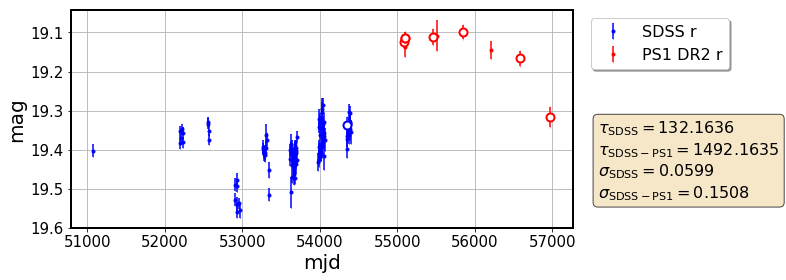

In [216]:
#data = Table.read('190606_Celerite_real_Jeff1.txt', format='ascii')

# select outliers 
x = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'])
y = np.log10(data['tauEXP_sdss-ps1'] / data['tauEXP_sdss'])

m = (y>1) & (x>0.4)
print(np.sum(m), '/', len(m))

lcnames = data[m]['lcname'].data

for lcname in lcnames[:1]:
    lc = plot_SDSS_PS1_single(lcname)

## Calculate for each  light curve median SDSS,PS1 as well as sigmaG  <a id='calcOffsets'></a>

Ok, now calculate not only median of SDSS and PS1 lcs, but also sigmaG.. 

In [3]:
#cleanDir = '../dp2/real_sdss_ps1r_dr2_cleaned/'
# this dir has some LCs where 
# since all PS1 points got flagged as 5 sigma outliers,
# only the SDSS portion is left (eg. dbID = 2092378)
# That's really a minority, but make sure that there is 
# both SDSS and PS1 in the combined 
# cleaned ligth curve to make that comparison 


# new cleaning procedure, flagging 10 sigma outliers, 
# manually inspecting 500 lcs, submitting 250 flares 
# and bad photometry to removal...
cleanDir = '../dp2/real_sdss_ps1r_dr2_cleaned_NEW/'
lcnames =  os.listdir(cleanDir)
res = {'lcname' : np.zeros_like(lcnames), 
       'PS1sigmaG' : np.zeros_like(lcnames, dtype=float),
       'PS1median': np.zeros_like(lcnames, dtype=float),
       'SDSSsigmaG': np.zeros_like(lcnames, dtype=float),
       'SDSSmedian': np.zeros_like(lcnames, dtype=float)
       }
i = 0 
for lcname in lcnames : 

    lc = Table.read(cleanDir + lcname, format='ascii')
    res['lcname'][i] = lcname
    # do this check to ensure that a LC has both SDSS 
    # and PS1 part ...  As described  above !  
    if np.sum(np.in1d(['sdss','ps1'], np.unique(lc['survey'].data))) > 1 : 
        for survey in ['sdss', 'ps1']:
            m = lc['survey'].data == survey
            x = lc['mag'][m].data
            sigmaG = 0.7413 * (np.percentile(x,75) - np.percentile(x,25))
            res[survey.upper()+'sigmaG'][i] = sigmaG
            res[survey.upper()+'median'][i] = np.median(x)
        i += 1 
        
summary = Table(res)
m = summary['PS1sigmaG'] == 0 
print('There are ', np.sum(m), ' for which the cleaning \
      process removed all PS1 data' )

summary.remove_rows(m)
summary.write('SDSS_PS1_DR2_cleaned_NEW_summary.txt', format='ascii', overwrite=True)

There are  9  for which the cleaning       process removed all PS1 data


Now,  take this summary table and join on dbID with DR7 to get ra, dec. If needed, given ra,dec can crossmatch  with Shen2011  to explore MBH, Lbol, redshift, etc.  (they are present in DR7 DBQSO, but are an older version from Shen2008) 


In [3]:
summary = Table.read('../code2/SDSS_PS1_DR2_cleaned_summary_NEW.txt', format='ascii') 
summary['dbID'] = [int(x[:-4]) for x in summary['lcname']]

File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
sdss_dbqso = Table.read(File, format='ascii', names = colnames)

summ = join(summary, sdss_dbqso, keys='dbID')



In [4]:
summary[:5]

lcname,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,dbID
str11,float64,float64,float64,float64,int64
1441903.txt,0.09467947905050439,20.44684082624815,0.06523440000000072,20.06,1441903
728791.txt,0.05909711553153627,19.542333807622004,0.061157250000002314,19.593,728791
908716.txt,0.041529414240830974,18.86184749601398,0.04818450000000095,18.679,908716
100520.txt,0.04306543842379066,18.60371612117568,0.03391447500000128,18.5345,100520
3759755.txt,0.08312846767948523,20.14833445456347,0.11934929999999837,20.108,3759755


Also, join the light curve median offsets between SDSS and PS1 with the results of Celerite fits, so we can directly correlate whether outliers in DRW parameters are also outliers in median offsets. 

In [5]:
celerite_fit = Table.read('../code2/190807_Celerite_real_Jeff1.txt', format='ascii')
celerite_fit.remove_row(0)
summ = join(summ, celerite_fit, keys='lcname')

Figure out how that compares to the numbers found when plotting the ratios ... 

In [24]:
data = summ 

m5 = data['tauEXP_sdss-ps1'] > 0 
m = m5 #&m3&m4&m5
print(np.sum(m), ' of ', len(m))

method = 'EXP'
x = np.log10(data['sigma'+method+'_sdss-ps1'][m] /\
             data['sigma'+method+'_sdss'][m] )
y = np.log10(data['tau'+method+'_sdss-ps1'][m]  /\
             data['tau'+method+'_sdss'][m] )

x0, y0, w, h  = [0.4,1.0, 0.3,0.5] 

# count objects in the tail-end of the distribution ... 
maskX = (x0<x)# * (x < (x0+w))
maskY = (y0<y)# * (y < (y0+h))
maskObj = maskX * maskY
print('\nThere are %d objects with x > %.2f, y > %.2f '%\
    (np.sum(maskObj), x0, y0))

# count objects in the rectangle 
maskX = (x0<x) * (x < (x0+w))
maskY = (y0<y) * (y < (y0+h))
maskObj = maskX * maskY
print('\nThe are %d objects in the rectangle'%np.sum(maskObj))

# select those with median PS1 r-mag < 20.5 
cutMag = 20.5 
maskMag = data['PS1median'] < cutMag
maskCans = maskObj * maskMag
print('\nOf these, %d have median PS1 r mag < %.2f'%(np.sum(maskCans), cutMag))

8507  of  8507

There are 65 objects with x > 0.40, y > 1.00 

The are 48 objects in the rectangle

Of these, 41 have median PS1 r mag < 20.50


In [25]:
data[maskCans]

lcname,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1
str11,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1003694.txt,0.017437924182495304,19.113106826982097,0.0491111250000001,19.396,1003694,20.309139,-1.053009,3067,-26.285,-26.622,1.8928,8.961,46.578,19.444,19.387,19.341,19.032,18.917,0.204,3321.0338459999984,0.05992165575003788,0.054034809545021247,132.1635529256881,67.25878533336956,5890.013739099995,0.16578012290767616,0.13896358631505498,1399.2029375397533,737.0768192780206
1124333.txt,0.04483004988447765,20.118233968922656,0.04169812499999894,19.8365,1124333,337.32605,-0.667659,74526,-24.496,-24.779,1.1626,8.677,45.801,20.243,20.115,19.775,19.731,19.974,0.347,2934.938688000002,0.054530357389015745,0.049578691591237255,38.24256384821139,11.96514951517627,5054.1875162,0.15632747579508827,0.13536320248543093,735.7187820262,337.1717800453856
1211045.txt,0.043749642751822755,19.539603583715248,0.04558994999999909,19.676,1211045,25.153179,0.531646,3847,-25.969,-26.471,2.1313,8.999,46.579,20.164,19.823,19.741,19.633,19.44,0.236,3321.0338239999983,0.03951411289198254,0.03830782481729835,26.05020867645228,0.09999999999999998,5507.071692699996,0.10344740891200471,0.09351834944231353,631.8356035694721,257.2994910852544
123909.txt,0.10747569523956114,20.48146572800598,0.05374425000000116,20.194499999999998,123909,4.110588,0.609013,587,-26.398,-26.744,3.2262,0.0,0.0,23.049,20.61,20.305,20.083,20.099,0.118,3321.0339959999983,0.0440324407124872,0.03892609863320452,84.59344148686787,24.446567578132278,5506.0793299,0.18107774794462045,0.14862677785045558,2128.709898573251,1112.0823342299614
1378415.txt,0.1685593162665916,20.015130609238827,0.055782825000000355,20.247500000000002,1378415,333.447205,0.32457,74020,-25.739,-26.253,2.305,8.54,46.381,20.904,20.37,20.291,20.053,19.668,0.265,2947.9454909999986,0.04252093163101083,0.038713030400019284,125.47601501185633,41.239804086492235,5057.3015075,0.16101820431733263,0.13278820042209455,1514.3963294993894,767.252201267228
1412379.txt,0.17138210702937146,20.043635508298614,0.11397487500000168,19.433500000000002,1412379,334.631622,-0.763599,74161,-25.221,-25.418,1.2328,9.447,46.16,19.685,19.62,19.224,19.192,19.341,0.462,2934.9386899999954,0.11253612312091454,0.09957976885032066,105.92950484252148,49.32754544085543,5054.207217499999,0.342778273825753,0.28283261258447134,1711.3004719475791,838.2908398448943
1446824.txt,0.05460096292601507,20.111273862911688,0.10211407499999772,19.749499999999998,1446824,331.036224,0.913698,73689,-25.967,-26.315,2.1094,9.451,46.639,19.991,19.831,19.757,19.616,19.365,0.248,2934.938694000004,0.08024050382270066,0.07483236187272826,53.4341092832408,19.79808206766036,5054.200521899998,0.21472242285722315,0.18834703982704243,1524.2365479832838,415.6962230244176
1644710.txt,0.047491881231190025,19.695700487605087,0.06968220000000089,19.418,1644710,33.245827,-0.097257,5138,-23.957,-24.529,0.8127,8.638,45.638,20.407,19.775,19.435,19.33,19.071,0.162,3336.9561269999977,0.08048945055931078,0.07221399528916472,88.84759960456114,47.103594257777075,5912.905862300002,0.20555160617919327,0.173822924784886,923.6463242828372,424.10995182832215
1815911.txt,0.08387069743770414,19.517692868554033,0.07561260000000022,19.039,1815911,328.241486,0.993574,73337,-25.199,-25.549,1.1306,9.07,46.117,19.396,19.316,18.977,18.984,19.147,0.405,2934.938703,0.07946066296446275,0.0710623427738596,145.79288139334227,36.07593478291509,5054.207067199997,0.25127646736786086,0.2065301396932805,2123.095457432777,1192.2986167058787


In [12]:

dataDir = '/
Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code2/'
obs = Table.read(dataDir + '190807_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
len(obs)

8516

In [14]:
obs[:4]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra_1,dec_1,SDR5ID_1,M_i_1,M_i_corr,redshift_1,mass_BH_1,Lbol,u,g,r,i,z,Au,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,d2d_chelsea,SDR5ID_2,ra_2,dec_2,redshift_2,M_i_2,mass_BH_2,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,SFinf,lambdaRF
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64
70.txt,3336.9332799999975,0.06622420604016294,0.05984751944546515,122.64636186715136,43.947398211560085,5512.08006,0.11528031304675211,0.08869122443954136,1051.6472826357199,104.17715718219792,70,2.169302,1.238649,301,-23.901,-24.181,1.073,0.0,0.0,20.793,20.469,20.197,20.04,20.0,0.116,000840.63+011419.1,2.1693060398101807,1.2386499643325806,1.073699951171875,45.52781425110629,7.523330610633552,1.5230929717266002,-0.09588690464482141,-24.28560773968867,0.0,301,2.169302,1.238649,1.073,-23.901,0.0,1.1926,1.90162,-0.686379,1.70316,3.08136,-0.957464,-0.627884,0,138.926,117.218,136.073,20.2857,60,0.09622425731393176,3014.954172696575
98.txt,2582.962741999996,0.17777734186818406,0.1425442932431927,925.3100717295334,346.4224029622469,4766.949499599999,0.22581749051089417,0.20385016619662305,221.1215053987094,120.00398107995377,98,1.091028,0.962126,144,-23.399,-23.576,0.7867,0.0,0.0,20.79,20.183,19.849,19.818,19.43,0.183,000421.84+005743.6,1.0910290479660034,0.9621239900588989,0.792900025844574,45.421472462631726,8.817950339204,0.1672667771274661,-1.4968484216898403,-23.96421289067481,0.0,144,1.091028,0.962126,0.7867,-23.399,0.0,1.27857,2.72909,-0.7177,2.6183,4.47248,-0.840168,-0.660262,0,123.092,75.9121,122.524,19.8702,52,0.23211252059810764,3498.0690658756366
233.txt,3321.0338420000044,0.10077753428200395,0.08457207262730722,656.3915732907483,193.68268108139895,5505.011707400001,0.09331905890615091,0.08190716477469642,589.5197608586575,206.62749524034126,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,000119.50+001038.0,0.33128899335861206,0.17722800374031067,1.62090003490448,45.95221191379889,8.921718166686233,0.20424216150370847,-1.0698767980049055,-25.008960685706665,0.0,58,0.331289,0.17723,1.6199,-24.735,0.0,1.19407,2.44022,-0.848145,2.24434,4.1202,-1.02269,-0.781607,0,134.36,107.71,132.865,20.3141,57,0.12325897950662115,2385.587236154052
1018.txt,3336.9333019999976,0.19664556428383365,0.1592889300085543,717.2540696348154,289.8007217518143,5130.080259599999,0.24073464521373225,0.19757244030604876,1046.4329548203557,482.01700688955657,1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,000527.52-000556.2,1.3646990060806274,-0.09895599633455276,0.6123999953269958,45.39391039241853,9.022211072036765,0.2674947222920013,-1.7286712247357983,-24.03915568655799,0.0,190,1.364696,-0.098956,0.6125,-23.121,0.0,1.12426,2.87294,-0.627733,2.72995,4.49924,-0.719803,-0.591494,0,152.593,82.2158,152.094,19.4742,62,0.33696948003053717,3875.968992248062


## Plot 4-panel offsets <a id='4panelOffsets'></a>

Now plot the histograms  ( all for combined r-band cleaned light curves , after sigma-clipping and day-averaging ) 

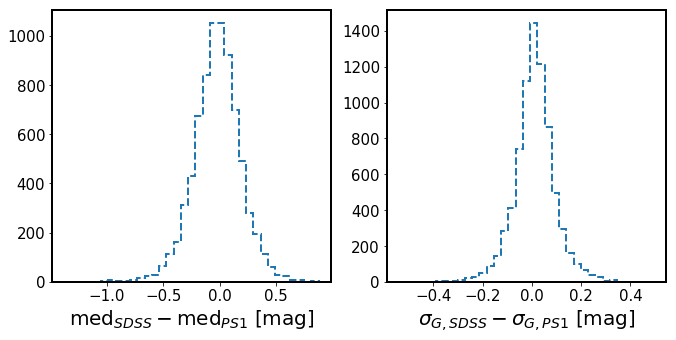

In [10]:
%matplotlib inline
fig,ax = plt.subplots(1,2, figsize=(11,5))

m = summ['SDSSmedian'] < 20.5

#ax[0].hist(summ['SDSSmedian'] - summ['PS1median'], ls='--', histtype='step',
#          lw=2, bins=35) # the distributions are so similar, 
# not worth comparing ... 
ax[0].hist(summ['SDSSmedian'][m] - summ['PS1median'][m], ls='--', histtype='step',
          lw=2, bins=35)
ax[0].set_xlabel(r'$\mathrm{med}_{SDSS}-\mathrm{med}_{PS1}$ [mag]')
ax[1].hist(summ['SDSSsigmaG'][m] - summ['PS1sigmaG'][m] , ls='--', histtype='step',
          lw=2,bins=35)
ax[1].set_xlabel(r'$\sigma_{G,SDSS}-\sigma_{G,PS1}$ [mag]')
plt.savefig('SDSS_PS1_DR2_cleaned_offsets_NEW.png', bbox_inches='tight', dpi=100)

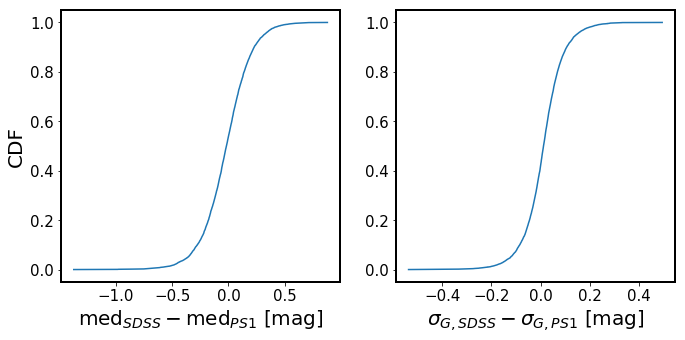

In [11]:
#### using "exact" empirical CDF 
#### based on https://stackoverflow.com/questions/10640759/how-to-get-the-cumulative-distribution-function-with-numpy 
m = summ['SDSSmedian'] < 20.5

fig,ax = plt.subplots(1,2, figsize=(11,5))
Z = summ['SDSSmedian'][m] - summ['PS1median'][m]
N = len(Z)
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)
ax[0].plot(X2, F2)
ax[0].set_ylabel('CDF')
ax[0].set_xlabel(r'$\mathrm{med}_{SDSS}-\mathrm{med}_{PS1}$ [mag]')

Z = summ['SDSSsigmaG'][m] - summ['PS1sigmaG'][m]
N = len(Z)
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)
ax[1].plot(X2, F2)
ax[1].set_xlabel(r'$\sigma_{G,SDSS}-\sigma_{G,PS1}$ [mag]')
plt.savefig('SDSS_PS1_DR2_cleaned_offsets_CDF_NEW.png', bbox_inches='tight', dpi=100)

## Fig.14 : Combine the two figures into a 4-panel plot : 

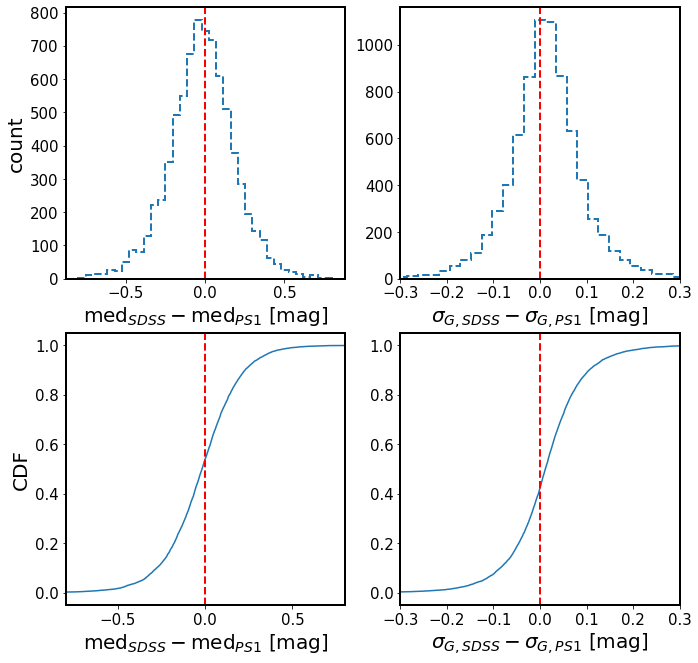

In [7]:
fig,axs = plt.subplots(2,2, figsize=(11,11))
ax  = np.ravel(axs)
m = summ['SDSSmedian'] < 20.5

medlims = [-0.8,0.8]
siglims = [-0.3,0.3]
#ax[0].hist(summ['SDSSmedian'] - summ['PS1median'], ls='--', histtype='step',
#          lw=2, bins=35) # the distributions are so similar, 
# not worth comparing ... 
ax[0].hist(summ['SDSSmedian'][m] - summ['PS1median'][m], ls='--', histtype='step',
          lw=2, bins=35, range=(medlims))
ax[0].set_xlabel(r'$\mathrm{med}_{SDSS}-\mathrm{med}_{PS1}$ [mag]')
ax[0].set_ylabel('count')

ax[1].hist(summ['SDSSsigmaG'][m] - summ['PS1sigmaG'][m] , ls='--', histtype='step',
          lw=2,bins=35, range=(-.4,.4))
ax[1].set_xlabel(r'$\sigma_{G,SDSS}-\sigma_{G,PS1}$ [mag]',)
ax[1].set_xlim(siglims)

#### using "exact" empirical CDF 
#### based on https://stackoverflow.com/questions/10640759/how-to-get-the-cumulative-distribution-function-with-numpy 
m = summ['SDSSmedian'] < 20.5

Z = summ['SDSSmedian'][m] - summ['PS1median'][m]
N = len(Z)
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)
ax[2].plot(X2, F2)
ax[2].set_xlim(medlims)
#ax[2].set_ylim(0,1)
ax[2].set_ylabel('CDF')
ax[2].set_xlabel(r'$\mathrm{med}_{SDSS}-\mathrm{med}_{PS1}$ [mag]')

Z = summ['SDSSsigmaG'][m] - summ['PS1sigmaG'][m]
N = len(Z)
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)
ax[3].plot(X2, F2)
ax[3].set_xlabel(r'$\sigma_{G,SDSS}-\sigma_{G,PS1}$ [mag]')
ax[3].set_xlim(siglims)

for i in range(len(ax)):
    ax[i].axvline(0,ls='--',lw=2, c='r')
plt.savefig('fig14.pdf', bbox_inches='tight', dpi=100)

How many outliers are there ?

In [76]:
m1 = summ['SDSSmedian'].data < 21
m2 = np.abs(summ['SDSSmedian'].data- summ['PS1median'].data)>0.7
m = m1&m2 
print(np.sum(m), np.sum(m1))
summ[m]

33 8388


lcname,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au
str11,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
223800.txt,0.03898157367989151,19.65622585069613,0.1994097000000014,18.908,223800,14.944415,0.048633,2332,-24.001,-24.288,0.6819,8.54,45.628,19.059,18.845,18.921,18.853,18.919,0.145
293690.txt,0.12521039895587271,21.071011628288204,0.063010499999998,20.301499999999997,293690,351.351685,-0.776233,76175,-23.791,-24.581,1.0823,0.0,0.0,20.691,20.638,20.219,20.215,20.107,0.226
338888.txt,0.3096556890682541,20.771445981286966,0.07190609999999834,19.852,338888,354.722717,-1.022067,76670,-25.186,-25.59,1.4879,9.143,46.119,20.536,20.223,19.795,19.555,19.587,0.169
580228.txt,0.25431449171705656,20.895851852995886,0.3454458000000008,20.16,580228,16.810339,-0.835196,2576,-22.502,-23.422,0.6512,8.012,45.378,21.106,20.766,20.577,20.276,20.036,0.235
720083.txt,0.23240393163715117,20.565763463155985,0.2029308749999998,19.7915,720083,340.627441,-0.133563,74915,-23.635,-23.507,0.8998,7.941,44.878,20.18,20.044,19.96,19.967,19.755,0.328
861520.txt,0.10184576227505235,20.883546153370055,0.2601962999999993,19.882,861520,342.350067,0.797352,75111,-24.554,-24.733,1.35,0.0,0.0,20.863,20.867,20.163,20.102,20.25,0.526
1042657.txt,0.17859642696675848,20.125389698693507,0.07413000000000106,19.318,1042657,337.151001,-0.534157,74503,-24.701,-25.364,1.0347,0.0,0.0,20.001,19.701,19.264,19.258,19.403,0.378
1108089.txt,0.14155704003039488,19.749944402104703,0.185880975,20.4955,1108089,338.543762,0.702794,74670,-22.88,-23.783,0.7801,0.0,0.0,21.489,20.751,20.531,20.422,20.054,0.443
1177097.txt,0.3832427916107877,20.73343024812948,0.1328780250000024,19.9815,1177097,335.486664,0.578915,74269,-25.229,-25.584,1.7299,0.0,0.0,20.598,20.367,20.276,19.938,19.936,0.35


Plot these light curves : <a id='plotOutlierLC'></a>
    
    

Saved as  SDSS_PS1_DR2_combined_lc_338888.png


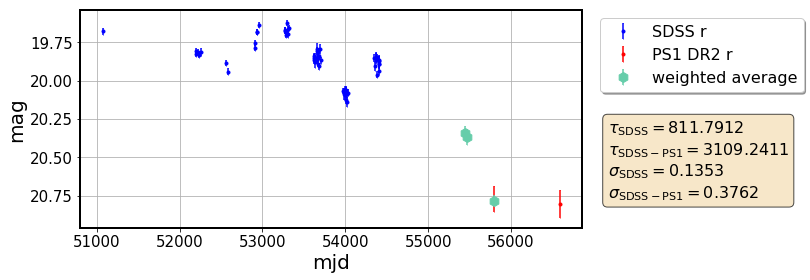

Saved as  SDSS_PS1_DR2_combined_lc_861520.png


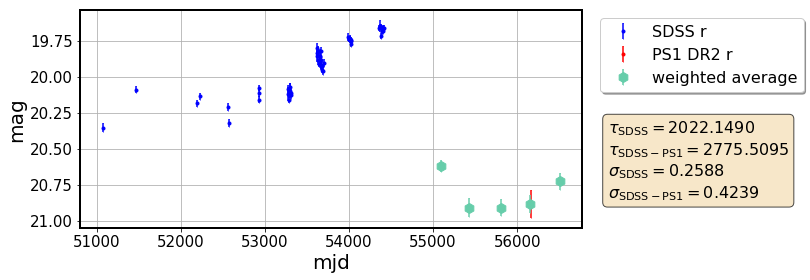

Saved as  SDSS_PS1_DR2_combined_lc_1042657.png


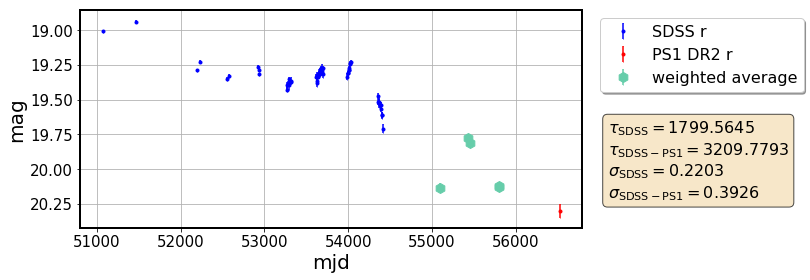

Saved as  SDSS_PS1_DR2_combined_lc_1475410.png


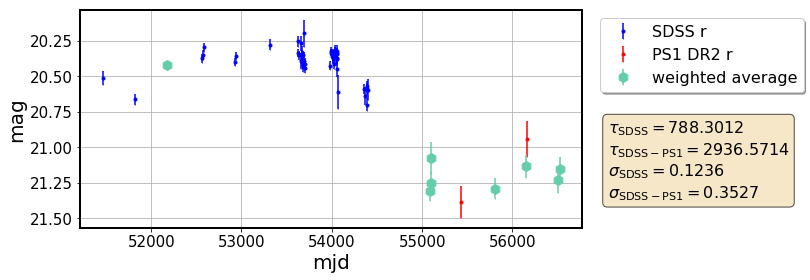

Saved as  SDSS_PS1_DR2_combined_lc_1696259.png


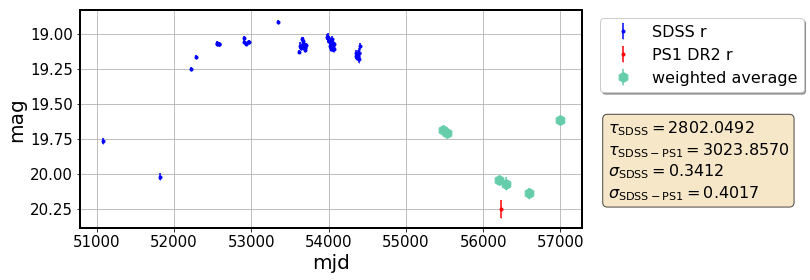

In [65]:
lcnames = summ[m]['lcname']
for lcname in lcnames[:5]:
    lc = plot_SDSS_PS1_single(lcname)

Compare the overlap between the outliers in  $\tau$-$\sigma$ space vs  those of median magnitude offsets... <a id='plotTauSigmaSpace'></a>

Mark the region in $\tau$ - $\sigma$ space occupied by the outliers. Store their names ...

44
8516  of  8516
Saved as  Compare_Celerite_SDSS-PS1_vs_SDSS_EXP_190606.png


/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code2/modules.py:97: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_y, bins_y = np.histogram(y, bins=33, normed=True, range=extent[2:])
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code2/modules.py:107: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_x, bins_x = np.histogram(x, bins=33, normed=True, range=extent[:2])


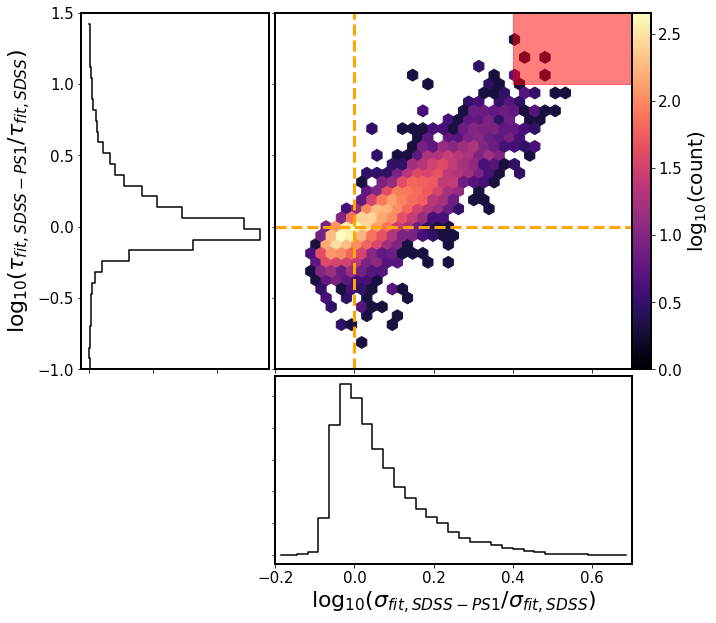

In [16]:
%matplotlib inline
import modules as mod
import imp
imp.reload(mod)
date = '190606'# '190606'# '190807'
data = Table.read(date + '_Celerite_real_Jeff1.txt', format='ascii')
x = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'])
y = np.log10(data['tauEXP_sdss-ps1'] / data['tauEXP_sdss'])
m_ratio = (y>1) & (x>0.4)
print(np.sum(m_ratio))
mod.plot_tau_sigma_ratios(data, date, rectangle=[0.4, 1, 0.5, 0.5])

Color by the median offsets...

8468  of  8468


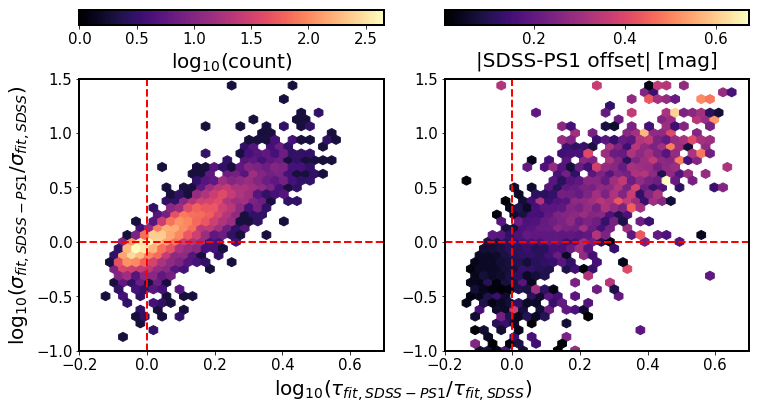

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import matplotlib as mpl
# the Celerite results 
date = '190807'
fname  = date+'_Celerite_real_Jeff1.txt'
data_cel = Table.read(fname, format='ascii')
data_cel.remove_row(0)
# the SDSS-PS1 offsets
summary = Table.read('SDSS_PS1_DR2_cleaned_summary.txt', format='ascii') 

# join on lcname
data = join(data_cel, summary, keys = 'lcname')

# an obvious cut, if nothing more stringent needed ... 
m5 = data['tauMAP_sdss-ps1'] > 0 
m = m5 #&m3&m4&m5
print(np.sum(m), ' of ', len(m))

x = np.log10(data['sigmaEXP_sdss-ps1'][m] / data['sigmaEXP_sdss'][m] )
y = np.log10(data['tauEXP_sdss-ps1'][m]  / data['tauEXP_sdss'][m] )
z = np.abs(data['PS1median'][m] - data['SDSSmedian'][m])

extent = [-0.2, 0.7, -1., 1.5 ]

xmin,xmax = extent[0], extent[1]
ymin,ymax = extent[2], extent[3]

fig,ax = plt.subplots(1,2,figsize=(12,5))

# left axis : color by count 
image = ax[0].hexbin(x, y, extent = extent, gridsize=35, 
      bins='log', vmin=1 , mincnt=2, cmap='magma')

# set bottom and height for both colorbars
bottom, height =  1.03, 0.04

# get left and right coordinates in figure units 
# for left axis 
l,b,w,h = ax[0].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])

vmin, vmax = image.get_clim()
norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
cmap.set_array([])
    
plt.colorbar(mappable = cmap, cax = cax, orientation='horizontal',
                label=r'$\log_{10}{(\mathrm{count})}$')
ls='--';lw=2; c='red'
ax[0].axvline(0,ls=ls,lw=lw,c=c)
ax[0].axhline(0,ls=ls,lw=lw,c=c)
ax[0].set_xlim(xmin,xmax)
ax[0].set_ylim(ymin,ymax)

string = r'$\log_{10}{\left( \sigma_{fit, %s} / \sigma_{fit,%s} \right)}$'%('SDSS-PS1','SDSS')
ax[0].set_ylabel(string)

# right axis:  color by median SDSS-PS1 r-band offset ...
image = ax[1].hexbin(x, y, z, extent = extent, gridsize=35, 
     cmap='magma')

# get left and right coordinates in figure units 
# for right axis 
l,b,w,h = ax[1].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])

vmin, vmax = image.get_clim()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
cmap.set_array([])
    
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
                label='|SDSS-PS1 offset| [mag]')

ax[1].axvline(0,ls=ls,lw=lw,c=c)
ax[1].axhline(0,ls=ls,lw=lw,c=c)
ax[1].set_xlim(xmin,xmax)
ax[1].set_ylim(ymin,ymax)

s= r'$\log_{10}{\left( \tau_{fit, %s} / \tau_{fit,%s} \right)}$'%('SDSS-PS1','SDSS')
fig.text(0.35,0.0, s, fontsize=20)

plt.savefig(date+'_DRW_param_ratios_and_mag_offsets.png', 
            bbox_inches='tight')

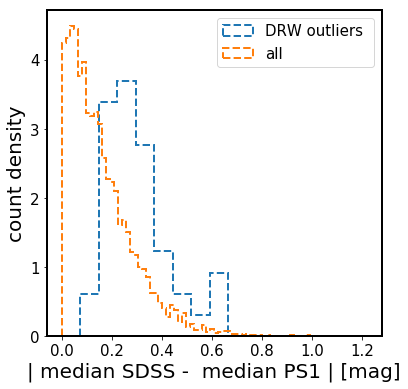

In [96]:
x = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'])
y = np.log10(data['tauEXP_sdss-ps1'] / data['tauEXP_sdss'])
m =  (y>1) & (x>0.4)

fig,ax = plt.subplots(1,1,figsize=(6,6))
off = np.abs(data['SDSSmedian']-data['PS1median'])

ax.hist(off[m], histtype='step', 
       ls='--', lw=2, label='DRW outliers ', density=True, bins='auto')
ax.hist(off,   histtype='step', 
       ls='--', lw=2, label='all', density=True,bins='auto')
ax.set_xlabel('| median SDSS -  median PS1 | [mag]')
ax.set_ylabel('count density')
ax.legend(fontsize=15)
plt.savefig('DRW_outliers_in_median_offset_space.png', bbox_inches='tight')

Include median magnitude cutoff...  Plot as subpanels   - 4 pages of 2x5 plots 

## Select CLQSO candidates : from offsets, Celerite results, and Shen2007, 2011<a id='select_clqso_cans'></a>

[toc](#toc)

In [201]:
# Read-in the Celerite results cross-matched with Shen2007 and 2011  databases (done in Compare_Celerite_Chelsea...)
date = '190807'#'190606'#'190807'#'190606'# '190807'
celerite = Table.read(date+'_Celerite_real_Jeff1_Shen2008-2011.txt',
                 format='ascii')

# Read the SDSS-PS1 offsets  calculated above,
# Using the light curves from ../dp2/real_sdss_ps1r_dr2_cleaned_NEW/
# that were used to calculate eg. 190807 results 
summary = Table.read('SDSS_PS1_DR2_cleaned_summary_NEW.txt', format='ascii') 

# join on lcname
data = join(celerite, summary, keys = 'lcname')


# select DRW outliers 
x = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'])
y = np.log10(data['tauEXP_sdss-ps1'] / data['tauEXP_sdss'])
m1 =  (y>1) & (x>0.4)

# add magnitude cutoff
#m2  = data['SDSSmedian']  < 20.5 
m2  = data['PS1median']  < 20.5 
# combined masks 
m = m1 & m2
print(np.sum(m))

# store the subset with 38 candidates... 
data.rename_column('SDSS_NAME', 'SDSSJID')
data_clqso = data[m].copy()


data_clqso.write('CLQSO_S82_candidates_'+date+'_PS1.txt', format='ascii',
                overwrite=True)

# split the table of 38 outliers into four sub arrays :
#x = np.arange(1,39)
#xs = np.array_split(x,4)
#ds  = np.array_split(data[m],4)

x = np.array(data_clqso)
NperPage = 10
Npages = (len(x) // NperPage)+1
print('Splitting into ', Npages , ' pages , with ', NperPage , ' objects per page')
indices_split = np.arange(NperPage,Npages*NperPage,NperPage)
ds = np.array_split(x,indices_split)
#print(len(ds))

# if (30 <np.sum(m) ) & (np.sum(m) < 40) : 
#     ds = [data[m][:10] , data[m][10:20] , data[m][20:30], data[m][30:] ]
    
# if (50 <np.sum(m) ) & (np.sum(m) < 60) :
#     ds = [data[m][:10] , data[m][10:20] , data[m][20:30], data[m][30:40],
#          data[m][40:50], data[m][50:]]
    
fname = 'CLQSO_S82_candidates_'+date+'_data'
print('Storing the partitioned sections of the data as ', 
     fname,'.npy')
np.save( fname, ds)



56
Splitting into  6  pages , with  10  objects per page
Storing the partitioned sections of the data as  CLQSO_S82_candidates_190807_data .npy


In [29]:
# do we get the same candidates in this search as before ? 
clqcans1 = Table.read('CLQSO_S82_38_candidates_190606.txt',format='ascii')
clqcans2 = data_clqso

np.sum(np.in1d(clqcans1['lcname'], clqcans2['lcname']))
# so 35/38 are in the larger 57 sources sample ... what are the ones
# that are new ? 

new = ~np.in1d(clqcans2['lcname'], clqcans1['lcname'])
clqcans2[new] # 22/57 are not in the other set .... 

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,SDSSJID,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1211045.txt,3321.0338239999983,0.03951411289198254,0.03830782481729835,26.05020867645228,0.09999999999999998,5507.071692699996,0.10344740891200471,0.09351834944231353,631.8356035694721,257.2994910852544,1211045,25.153179,0.531646,3847,-25.969,-26.471,2.1313,8.999,46.579,20.164,19.823,19.741,19.633,19.44,0.236,014036.76+003153.8,25.1531982421875,0.5316359996795654,2.131500005722046,46.56507916945386,8.998388604368158,0.1532591527837728,-0.533679980031863,-26.42210719478759,0.043749642751822755,19.539603583715248,0.04558994999999909,19.676
1446824.txt,2934.938694000004,0.08024050382270066,0.07483236187272826,53.4341092832408,19.79808206766036,5054.200521899998,0.21472242285722315,0.18834703982704243,1524.2365479832838,415.6962230244176,1446824,331.036224,0.913698,73689,-25.967,-26.315,2.1094,9.451,46.639,19.991,19.831,19.757,19.616,19.365,0.248,220408.69+005449.3,331.0362243652344,0.9136949777603149,2.1110000610351562,46.62394522288803,9.342523923306324,0.10632417006973606,-0.8189492455358547,-26.366183872818926,0.05460096292601507,20.111273862911688,0.10211407499999772,19.749499999999998
1683846.txt,3330.930358999998,0.06708287609289096,0.060640103900769134,140.8557801359403,79.3557698732561,5912.934265699994,0.2566903704655979,0.21227905365761388,2217.7797355999337,1200.2374441438055,1683846,32.162239,-0.064498,4976,-24.901,-25.16,1.5516,8.959,45.955,20.417,20.251,20.114,19.929,19.938,0.144,020838.93-000352.2,32.16224670410156,-0.06449999660253525,1.5505000352859497,45.934375711564606,9.292900320836742,0.1429467839228812,-1.458895154389701,-25.1360664464502,0.1898738218395923,20.590225811676923,0.06023062499999789,20.252499999999998
1815911.txt,2934.938703,0.07946066296446275,0.0710623427738596,145.79288139334227,36.07593478291509,5054.207067199997,0.25127646736786086,0.2065301396932805,2123.095457432777,1192.2986167058787,1815911,328.241486,0.993574,73337,-25.199,-25.549,1.1306,9.07,46.117,19.396,19.316,18.977,18.984,19.147,0.405,215257.95+005936.8,328.2414855957031,0.9935700297355652,1.1288000345230103,46.12302688323227,9.077304145686274,0.13249572276199545,-1.0546478075715626,-25.517751968517324,0.08387069743770414,19.517692868554033,0.07561260000000022,19.039
1835106.txt,2947.945418000003,0.06631624879645834,0.05929181803747112,109.28340534536729,48.962908863312144,5057.310371899999,0.3269264397982007,0.2801789057945797,2626.4769864070972,1725.5677832945755,1835106,327.562744,-0.892076,73257,-25.751,-26.241,1.901,9.191,46.39,20.484,20.243,20.02,19.668,19.572,0.432,215015.05-005331.4,327.562744140625,-0.8920739889144897,1.902400016784668,46.334828057675466,9.21136100352135,0.11449369673180482,-0.9769034909634442,-26.064170072691976,0.045047323311794965,19.279276791872736,0.08024572500000128,19.973
226040.txt,3336.9332850000064,0.04500022725217913,0.04379471240481482,7.4353937380978845,0.09999999999999998,5512.053447700004,0.1271923641735177,0.11147405380107912,949.8829810352918,313.0505057100866,226040,13.333115,0.307237,2091,-25.077,-25.553,1.6067,8.765,46.044,20.425,20.123,19.989,19.832,19.655,0.138,005319.94+001826.0,13.333122253417969,0.30722901225090027,1.6068999767303467,46.08430213637126,8.406705980165308,0.18505204904031633,-0.4227743889116127,-25.333689024621176,0.1873029627269482,20.054850506593272,0.04373670000000078,19.9625
2428268.txt,2582.962744000004,0.07163360510738191,0.06720016423278

In [37]:
missing = ~np.in1d(clqcans1['lcname'], clqcans2['lcname'])

clqcans1['logSigRatio']  = np.log10(clqcans1['sigmaEXP_sdss-ps1'] / clqcans1['sigmaEXP_sdss'])
clqcans1['logTauRatio']  = np.log10(clqcans1['tauEXP_sdss-ps1'] / clqcans1['tauEXP_sdss'])
clqcans1[missing][['lcname', 'logSigRatio', 'logTauRatio']]

lcname,logSigRatio,logTauRatio
str11,float64,float64
612585.txt,0.4089007633082346,1.0311856005681288
2069362.txt,0.4791999714824645,1.0279470603588585
3916393.txt,0.5227855492472334,1.0021371464058575


In [42]:
data['logSigRatio']  = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'])
data['logTauRatio']  = np.log10(data['tauEXP_sdss-ps1'] / data['tauEXP_sdss'])
mask = np.in1d(data['lcname'],clqcans1[missing]['lcname'])
data[mask][['lcname', 'logSigRatio', 'logTauRatio']]

lcname,logSigRatio,logTauRatio
str11,float64,float64
2069362.txt,0.06802015731393571,0.05050800743614443
3916393.txt,0.5531772500868655,0.9548486205274953
612585.txt,0.3797865099144963,0.9358592935362264


In [30]:

#name = '190606_Celerite_real_Jeff1_dr5_7.txt'
#data = Table.read(name, format='ascii')




# based on 190606 
# before called CLQSO_S82_38_candidates_FULL.txt   --> renamed 
# to CLQSO_S82_38_candidates_190606.txt  , for better bookkeeping 
#data_clqso.write('CLQSO_S82_38_candidates_190606.txt', format='ascii',
#                overwrite=True)


# split the table of 38 outliers into four sub arrays :
#x = np.arange(1,39)
#xs = np.array_split(x,4)
#ds  = np.array_split(data[m],4)
ds = [data[m][:10] , data[m][10:20] , data[m][20:30], data[m][30:] ]


### TESTING MULTI_PANEL CODE 

Text(0.5, 1.0, 'dbID=1003694')

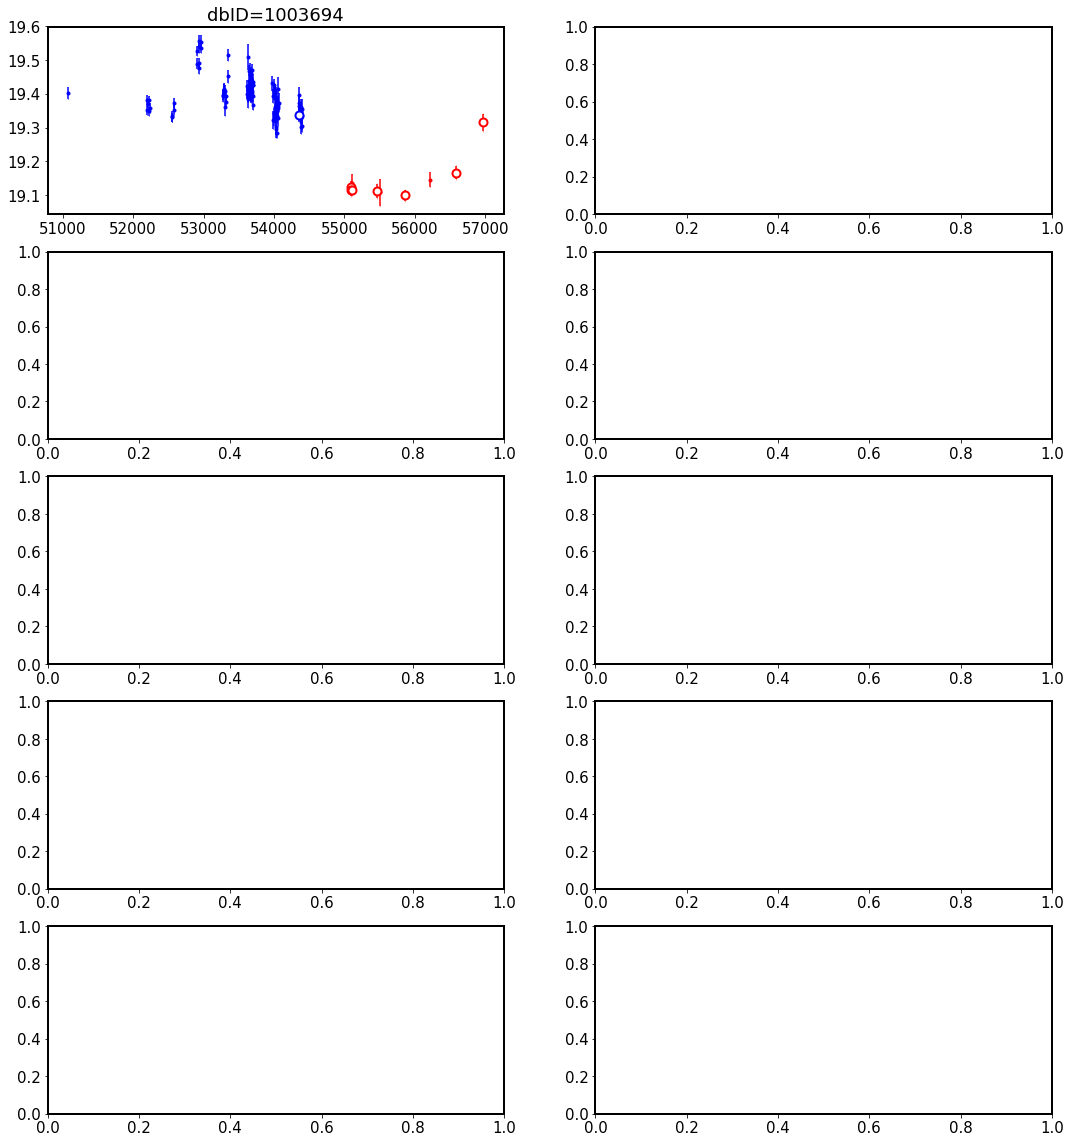

In [68]:
fig,axs = plt.subplots(5,2,figsize=(18,20))
ax = np.ravel(axs)
i = 0 
page = 0 
lcname = ds[page]['lcname'][i]
# plot the combined sdss - ps1 light curve, during cleaning, but 
# before day - averaging ... 
botDircleaning = '../dp2/real_sdss_ps1r_dr2_cleaning/' 
# has all the intermediate data products : 
# mjd, mag,  magerr, Nobs,  avgmag,  medmag,  avgerr 
lc = Table.read(botDircleaning+lcname, format='ascii')

colors = ['blue','red']
labels = ['SDSS r', 'PS1 DR2 r']
j = 0 
# plot what is kept in the cleaned light curve  - 
# sdss, ps1 days with Nobs =1 , which are kept unchanged 
for s in ['sdss','ps1']:
    rows = (lc['survey'] == s ) & (lc['Nobs'] == 1 )
    ax[i].errorbar(lc['mjd'][rows], lc['mag'][rows], 
             lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
           c = colors[j])
    j += 1 

# and with a different color : days for which 
# Nobs > 1, for which we find  avg mag  and median mag ,
# but plot only avg mag, since there is not much 
# difference between that and median mag, 
# and that's the one that we chose to keep in the 
# cleaned light curve 
lc1 = unique(lc[lc['Nobs'] > 1], keys='mjdint')

# plot the avg err with avg err 
j = 0
for s in ['sdss','ps1']:
    rows = (lc1['survey'] == s )
    ax[i].errorbar(lc1['mjd'][rows], lc1['avgmag'][rows], lc1['avgerr'][rows], 
               fmt="o", capsize=0.2, markersize=8,
             c = colors[j], mfc='white', mew=2 , label='')
    # markerfacecolor or mfc  = 'white' makes an open circle 
    # markeredgewidth or mew = 2 makes the edge of the circle thicker than default 
    j += 1 

    
# plot data from other surveys ... 
colors = ['orange','green', 'magenta']
labels = ['CRTS V', 'PTF R', 'ZTF r']
filterCode  = ['w', '2', 'r']
# try this first:  combined with SDSS offsets..
lcDir = '../dp2/real_combined_r/'
# read in the full LC, with offsets to SDSS r 
lcF = Table.read(lcDir+lcname, format='ascii')
surveys = np.unique(lcF['originSurvey'].data)
j = 0 
for s in ['crts', 'ptf', 'ztf']:
    if s in surveys : 
        rows = (lcF['originSurvey'] == s ) & (lcF['originBand'] == filterCode[j])
        if np.sum(rows)>0:
            # select part of the light curve that corresponds 
            # to that survey 
            lc = lcF[rows]

            # do day averaging
            lc['mjdint'] = lc['mjd'].astype(int)
            lc['Nobs']  = 1
            lc['medmag'] = lc['mag']
            lc['avgmag'] = lc['mag'] # same with avgmag ...  
            lc['avgerr'] = lc['magerr'] # same with err  ...  


            # find out which days have more than 1 obs 
            value, count = np.unique(lc['mjdint'], return_counts=True)

            # for those that do, update the value of Nobs, 
            # and populate the medmag with the median of these days 
            for mjd in value[count > 1] : 
                rows = lc['mjdint'] == mjd
                lc['Nobs'][rows] = count[value == mjd]
                lc['medmag'][rows] = np.ma.median(lc['mag'][rows])

                weights = 1.0 / (lc['magerr'][rows] * lc['magerr'][rows])
                average = np.sum(weights * lc['mag'][rows]) / np.sum(weights)

                lc['avgmag'][rows] = average
                avgerr  = 1.0 / (np.sqrt(np.sum(weights)))
                # if error < 0.02 , we add 0.01 in quadrature ... 
                if avgerr < 0.02 : 
                    avgerr  = np.sqrt(avgerr**2 + 0.01**2)
                lc['avgerr'][rows] = avgerr
                
            # finally, keep only one of the day-averaged products
            #lcU = unique(lc, keys='mjdint')
            
            # plot the days where there was only one obs 
            # plot the original value 
            rows = lc['Nobs'] == 1 
            if np.sum(rows) > 0:
                ax[i].errorbar(lc['mjd'][rows], lc['mag'][rows], 
                lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
                c = colors[j])
                
                
            # plot the averages for days with more than one obs
            rows = lc['Nobs'] > 1 
            if np.sum(rows) > 0:
                lcU = unique(lc[rows], keys='mjdint')
                ax[i].errorbar(lcU['mjd'], lcU['avgmag'], 
                     lcU['avgerr'],  fmt="o", capsize=0.2, markersize=8,
                   c = colors[j], mfc='white', mew=2 , label='', alpha=0.5)
            # markerfacecolor or mfc  = 'white' makes an open circle 
        # markeredgewidth or mew = 2 makes the edge of the circle thicker than default 
        j += 1 



ax[i].set_title('dbID='+lcname[:-4])

In [69]:
unique(lc[lc['Nobs'] > 1], keys='mjdint')

mag,magerr,mjd,survey,mjdint,Nobs,medmag,avgmag,avgerr
float64,float64,float64,str4,int64,int64,float64,float64,float64
19.309,0.038,54359.322025,sdss,54359,2,19.3285,19.337543335022808,0.022071808348454534
19.124378419881257,0.01678567318156805,55090.5345876,ps1,55090,2,19.125295009719444,19.125275848315237,0.015614881062042918
19.13933805004104,0.020459836789286808,55095.5050156,ps1,55095,2,19.118421770837347,19.115190332474725,0.01664231051058088
19.133536146849302,0.017988460883206096,55102.5129258,ps1,55102,2,19.115725298504206,19.115585247439036,0.01614063658841344
19.105022465734052,0.02661238846107948,55467.4618342,ps1,55467,2,19.110596254761006,19.111023321489473,0.02066343485641277
19.102187053457307,0.020560567234250746,55853.3692186,ps1,55853,2,19.098962046477954,19.09889494542955,0.017520577286987554
19.17543801300153,0.02962632782907379,56587.3921819,ps1,56587,2,19.167205240770617,19.166608421557505,0.020175364979825524
19.31032981166441,0.03358877564282083,56971.3518861,ps1,56971,2,19.316362446396663,19.315856507516255,0.02472675748107498


do day-averaging of PTF and CRTS data ... should really improve the data quality ! 

<ErrorbarContainer object of 3 artists>

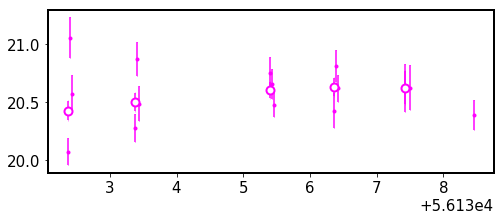

In [251]:


# plot before day-averaging 
fig,ax = plt.subplots(1,1,figsize=(8,3))
ax.errorbar(lc['mjd'], lc['mag'], 
             lc['magerr'], fmt=".", capsize=0.2, label=labels[j],
             c = colors[j])

# plot after day-averaging
ax.errorbar(lcU['mjd'], lcU['avgmag'], lcU['avgerr'], 
               fmt="o", capsize=0.2, markersize=8,
             c = colors[j], mfc='white', mew=2 , label='')


In [301]:
lcname[:-4]

'8442'

8442.txt


<ErrorbarContainer object of 3 artists>

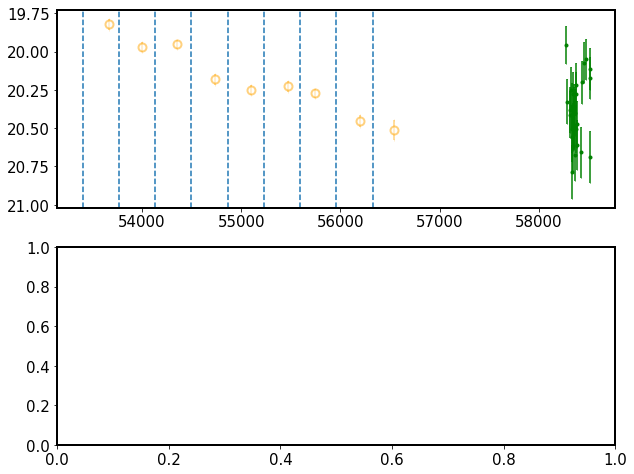

In [302]:
i = 0 
j = 0
page = 0 
lcname = ds[page]['lcname'][i]
print(lcname)
fig,ax = plt.subplots(2,1,figsize=(10,8))
lcDir = '../dp2/real_combined_r/'
# read in the full LC, with offsets to SDSS r 
lcF = Table.read(lcDir+lcname, format='ascii')
surveys = np.unique(lcF['originSurvey'].data)
filterCode  = ['w', '2', 'r']

s = 'crts'
rows = lcF['originSurvey'] == s 
if np.sum(rows)>0:
    # select part of the light curve that corresponds 
    # to that survey 
    lc = lcF[rows]

    # first remove 7sigma error outliers
    Nsig = 7
    sigmaGerr =  0.7413 * (np.percentile(lc['magerr'],75) -\
                         np.percentile(lc['magerr'],25))
    Nstdev = np.abs(np.ma.median(lc['magerr']) -\
                    lc['magerr']) / sigmaGerr
    merr = Nstdev  > Nsig
    lc.remove_rows(merr)

    # then remove the 7sigma mag outliers
    Nsig = 7
    sigmaGmag =  0.7413 * (np.percentile(lc['mag'],75) -\
                        np.percentile(lc['mag'],25))
    Nstdev = np.abs(np.ma.median(lc['mag']) - lc['mag'])/sigmaGmag
    msig =  Nstdev > Nsig
    # store the information as a flag 
    #lc['flare'] = 0
    #lc['flare'][msig] = 1 
    lc.remove_rows(msig)

    
    # seasonal window averaging ...
    #dt = 365
    #minT =  min(lc['mjd'])-1
    #maxT = max(lc['mjd'])
    # tWin =  np.arange(minT,maxT,dt)
    t = Time(lc['mjd'],  format='mjd')
    yearStart = min(t.datetime).year
    yearEnd = max(t.datetime).year+2
    seasons = Time([str(year)+'-02-01' for year in np.arange(yearStart, yearEnd)])

    # do seasonal averaging .... 
    lc['season'] = 0
    for k in range(len(seasons)-1):
        # illustrate and calculate seasons 
        ax[i].axvline(seasons[k].mjd, ls='--')
        rows = (seasons[k] < t ) & (t  <seasons[k+1])
        lc['season'][rows] = k
    
    # do day averaging
    #lc['mjdint'] = lc['mjd'].astype(int)
    
    lc['Nobs']  = 1
    lc['medmag'] = lc['mag']
    lc['avgmag'] = lc['mag'] # same with avgmag ...  
    lc['avgerr'] = lc['magerr'] # same with err  ...  

   
    # find out which days have more than 1 obs 
    #value, count = np.unique(lc['mjdint'], return_counts=True)

    # seasonal
    value, count = np.unique(lc['season'], return_counts=True)

    # for those that do, update the value of Nobs, 
    # and populate the medmag with the median of these days 
    for season in value[count > 1] : 
        rows = lc['season'] == season
        lc['Nobs'][rows] = count[value == season]
        lc['medmag'][rows] = np.ma.median(lc['mag'][rows])

        weights = 1.0 / (lc['magerr'][rows] * lc['magerr'][rows])
        average = np.sum(weights * lc['mag'][rows]) / np.sum(weights)

        lc['avgmag'][rows] = average
        avgerr  = 1.0 / (np.sqrt(np.sum(weights)))
        # if error < 0.02 , we add 0.01 in quadrature ... 
        if avgerr < 0.02 : 
            avgerr  = np.sqrt(avgerr**2 + 0.01**2)
        lc['avgerr'][rows] = avgerr

    # finally, keep only one of the day-averaged products
    #lcU = unique(lc, keys='mjdint')

    # plot the days where there was only one obs 
    # plot the original value 
    rows = lc['Nobs'] == 1 
    if np.sum(rows) > 0:
        ax[i].errorbar(lc['mjd'][rows], lc['mag'][rows], 
        lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
        c = colors[j])


    # plot the averages for days with more than one obs
    rows = lc['Nobs'] > 1 
    if np.sum(rows) > 0:
        lcU = unique(lc[rows], keys='season')
        ax[i].errorbar(lcU['mjd'], lcU['avgmag'], 
             lcU['avgerr'],  fmt="o", capsize=0.2, markersize=8,
           c = colors[j], mfc='white', mew=2 , label='', alpha=0.5)
    # markerfacecolor or mfc  = 'white' makes an open circle 
        # markeredgewidth or mew = 2 makes the edge of the circle thicker than default 
        
    ax[i].invert_yaxis()
    
    
    
    
# add ZTF data .... 
m = ztf['dbID'] == int(lcname[:-4])
filterid = np.array(ztf[m]['filterid'][0][1:-1].split(',')).astype(int)
mjd = np.array(ztf[m]['mjd'][0][1:-1].split(',')).astype(float)
mag = np.array(ztf[m]['mag'][0][1:-1].split(',')).astype(float)
magerr  = np.array(ztf[m]['magerr'][0][1:-1].split(',')).astype(float)

# choose only ZTFr.... 
r = filterid == 2
ax[i].errorbar(mjd[r], mag[r], magerr[r],  fmt=".", capsize=0.2, label=labels[j],
              c = colors[j+1])

In [ ]:
ztf= Table.read('../raw_data/ztf_dr1_s82_qso_lcs.tbl', format='ipac')

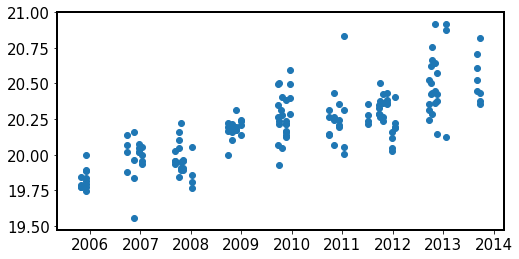

In [275]:
from astropy.time import Time
t = Time(lc['mjd'], format='mjd')
import matplotlib.dates as mdates
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.scatter(t.datetime, lc['mag'])
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

In [298]:
ztf= Table.read('../raw_data/ztf_dr1_s82_qso_lcs.tbl', format='ipac')

In [90]:
from astropy.time import Time
def print_lc_page(ds, page, figname,
                  lcCleaningDir = '../dp2/real_sdss_ps1r_dr2_cleaning/',
                  otherSurveys = True):#, otherSurveys = False ):
    #ylims_dic =  {'min':np.zeros(10), 'max':np.zeros(10) , 'span' : np.zeros(10) }
    fig,axs = plt.subplots(5,2,figsize=(18,20))
    ax = np.ravel(axs)
    for i in range(len(ds[page])): 
        lcname = ds[page]['lcname'][i]
        # plot the combined sdss - ps1 light curve, during cleaning, but 
        # before day - averaging ... 
        #botDircleaning = '../dp2/real_sdss_ps1r_dr2_cleaning/'
        # has all the intermediate data products : 
        # mjd, mag,  magerr, Nobs,  avgmag,  medmag,  avgerr 
        lc = Table.read(lcCleaningDir+lcname, format='ascii')

        colors = ['blue','red']
        labels = ['SDSS r', 'PS1 DR2 r']
        j = 0 
        # plot what is kept in the cleaned light curve  - 
        # sdss, ps1 days with Nobs =1 , which are kept unchanged 
        
        # don't plot flares : NEW column in 
        # real_sdss_ps1r_dr2_cleaning_NEW/
        #if 'flare' in lc.colnames :
        #    Nflares = np.sum(lc['flare'])
        #    if Nflares > 0 : 
        #        lc = lc[lc['flare'] == 0]
        #        print('Not plotting ', Nflares, ' flares')
        
        for s in ['sdss','ps1']:
            rows = (lc['survey'] == s ) & (lc['Nobs'] == 1 )
            ax[i].errorbar(lc['mjd'][rows], lc['mag'][rows], 
                     lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
                   c = colors[j])
            j += 1 

        # and with a different color : days for which 
        # Nobs > 1, for which we find  avg mag  and median mag ,
        # but plot only avg mag, since there is not much 
        # difference between that and median mag, 
        # and that's the one that we chose to keep in the 
        # cleaned light curve 
        lc1 = unique(lc[lc['Nobs'] > 1], keys='mjdint')

        # plot the avg err with avg err 
        j = 0
        for s in ['sdss','ps1']:
            rows = (lc1['survey'] == s )
            ax[i].errorbar(lc1['mjd'][rows], lc1['avgmag'][rows], lc1['avgerr'][rows], 
                       fmt="o", capsize=0.2, markersize=8,
                     c = colors[j], mfc='white', mew=2 , label='')
            # markerfacecolor or mfc  = 'white' makes an open circle 
            # markeredgewidth or mew = 2 makes the edge of the circle thicker than default 
            j += 1 
            
        if otherSurveys : 
            # plot data from other surveys ... 
            colors = ['orange','green', 'magenta']
            labels = ['CRTS V', 'PTF R', 'ZTF r']
            filterCode  = ['w', '2', 'r']
            # try this first:  combined with SDSS offsets..
            lcDir = '../dp2/real_combined_r/'
            # read in the full LC, with offsets to SDSS r 
            lcF = Table.read(lcDir+lcname, format='ascii')
            surveys = np.unique(lcF['originSurvey'].data)
            j = 0 
            for s in ['crts', 'ptf', 'ztf']:
                if s in surveys : 
                    rows = (lcF['originSurvey'] == s ) & \
                           (lcF['originBand'] == filterCode[j])
                    if np.sum(rows)>0:
                        # select part of the light curve that corresponds 
                        # to that survey 
                        lc = lcF[rows]

                        # first remove 7sigma error outliers
                        Nsig = 7
                        sigmaGerr =  0.7413 * (np.percentile(lc['magerr'],75) -\
                                             np.percentile(lc['magerr'],25))
                        Nstdev = np.abs(np.ma.median(lc['magerr']) -\
                                        lc['magerr']) / sigmaGerr
                        merr = Nstdev  > Nsig
                        lc.remove_rows(merr)

                        # then remove the 7sigma mag outliers
                        Nsig = 7
                        sigmaGmag =  0.7413 * (np.percentile(lc['mag'],75) -\
                                            np.percentile(lc['mag'],25))
                        Nstdev = np.abs(np.ma.median(lc['mag']) - lc['mag'])/sigmaGmag
                        msig =  Nstdev > Nsig
                        # store the information as a flag 
                        #lc['flare'] = 0
                        #lc['flare'][msig] = 1 
                        lc.remove_rows(msig)

                        # do day averaging
                        day_averaging = False
                        if day_averaging : 
                            lc['mjdint'] = lc['mjd'].astype(int)
                            lc['Nobs']  = 1
                            lc['medmag'] = lc['mag']
                            lc['avgmag'] = lc['mag'] # same with avgmag ...  
                            lc['avgerr'] = lc['magerr'] # same with err  ...  


                            # find out which days have more than 1 obs 
                            value, count = np.unique(lc['mjdint'], return_counts=True)

                            # for those that do, update the value of Nobs, 
                            # and populate the medmag with the median of these days 
                            for mjd in value[count > 1] : 
                                rows = lc['mjdint'] == mjd
                                lc['Nobs'][rows] = count[value == mjd]
                                lc['medmag'][rows] = np.ma.median(lc['mag'][rows])

                                weights = 1.0 / (lc['magerr'][rows] * lc['magerr'][rows])
                                average = np.sum(weights * lc['mag'][rows]) / np.sum(weights)

                                lc['avgmag'][rows] = average
                                avgerr  = 1.0 / (np.sqrt(np.sum(weights)))
                                # if error < 0.02 , we add 0.01 in quadrature ... 
                                if avgerr < 0.02 : 
                                    avgerr  = np.sqrt(avgerr**2 + 0.01**2)
                                lc['avgerr'][rows] = avgerr

                            # finally, keep only one of the day-averaged products
                            #lcU = unique(lc, keys='mjdint')

                            # plot the days where there was only one obs 
                            # plot the original value 
                            rows = lc['Nobs'] == 1 
                            if np.sum(rows) > 0:
                                ax[i].errorbar(lc['mjd'][rows], lc['mag'][rows], 
                                lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
                                c = colors[j])


                            # plot the averages for days with more than one obs
                            rows = lc['Nobs'] > 1 
                            if np.sum(rows) > 0:
                                lcU = unique(lc[rows], keys='mjdint')
                                ax[i].errorbar(lcU['mjd'], lcU['avgmag'], 
                                     lcU['avgerr'],  fmt="o", capsize=0.2, markersize=8,
                                   c = colors[j], mfc='white', mew=2 , label='', alpha=0.5)
                        # markerfacecolor or mfc  = 'white' makes an open circle 
                        # markeredgewidth or mew = 2 makes the edge of the circle thicker than default 

                        season_averaging = True
                        if season_averaging:
                            t = Time(lc['mjd'],  format='mjd')
                            yearStart = min(t.datetime).year
                            yearEnd = max(t.datetime).year+2
                            seasons = Time([str(year)+'-02-01' for year in np.arange(yearStart, yearEnd)])

                            # do seasonal averaging .... 
                            lc['season'] = 0
                            for k in range(len(seasons)-1):
                                # illustrate and calculate seasons 
                                ax[i].axvline(seasons[k].mjd, ls='--')
                                rows = (seasons[k] < t ) & (t  <seasons[k+1])
                                lc['season'][rows] = k

                            lc['Nobs']  = 1
                            lc['medmag'] = lc['mag']
                            lc['avgmag'] = lc['mag'] # same with avgmag ...  
                            lc['avgerr'] = lc['magerr'] # same with err  ...  

                            # seasonal
                            value, count = np.unique(lc['season'], return_counts=True)

                            # for those that do, update the value of Nobs, 
                            # and populate the medmag with the median of these days 
                            for season in value[count > 1] : 
                                rows = lc['season'] == season
                                lc['Nobs'][rows] = count[value == season]
                                lc['medmag'][rows] = np.ma.median(lc['mag'][rows])

                                weights = 1.0 / (lc['magerr'][rows] * lc['magerr'][rows])
                                average = np.sum(weights * lc['mag'][rows]) / np.sum(weights)

                                lc['avgmag'][rows] = average
                                avgerr  = 1.0 / (np.sqrt(np.sum(weights)))
                                # if error < 0.02 , we add 0.01 in quadrature ... 
                                if avgerr < 0.02 : 
                                    avgerr  = np.sqrt(avgerr**2 + 0.01**2)
                                lc['avgerr'][rows] = avgerr


                            # plot the seasons where there was only one obs 
                            # plot the original value 
                            rows = lc['Nobs'] == 1 
                            if np.sum(rows) > 0:
                                ax[i].errorbar(lc['mjd'][rows], lc['mag'][rows], 
                                lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
                                c = colors[j])


                            # plot the averages for seasons with more than one obs
                            rows = lc['Nobs'] > 1 
                            if np.sum(rows) > 0:
                                lcU = unique(lc[rows], keys='season')
                                ax[i].errorbar(lcU['mjd'], lcU['avgmag'], 
                                     lcU['avgerr'],  fmt="o", capsize=0.2, markersize=8,
                                   c = colors[j], mfc='white', mew=2 , label='', alpha=0.5)
                    j += 1 

        ax[i].set_title('dbID='+lcname[:-4])
        ylim = ax[i].get_ylim()
        ymin, ymax =  min(ylim), max(ylim)
        span = ymax - ymin
        #ylims_dic['min'][i] = ymin
        #ylims_dic['max'][i] = ymax
        #ylims_dic['span'][i] = span 

        # increase the vertical span by  0.5 mag  if 
        # less than 0.5 .... 
        min_span = 0.5
        if span  < min_span : 
            ymin_new = ymin - min_span / 2.
            ymax_new = ymax + min_span / 2.
            ax[i].set_ylim(ymin_new, ymax_new)

        ax[i].invert_yaxis()
        
    if len(ds[page]) < 10 :
        for i in range(len(ds[page]),10) :
            ax[i].axis('off')
        
    # set the same span for all panels , equal to the 
    # largest span in a light curve on that page ... 
    # span = max(ylims_dic['span'])
    # for i in range(10):
    #     ymed = ylims_dic['min'][i] + ylims_dic['span'][i] / 2.
    #     ymin_new = ymed - span/2.
    #     ymax_new = ymed + span/2.
    #     ax[i].set_ylim(ymin_new,ymax_new)

    fig.subplots_adjust(hspace=0.3)
    plt.savefig(figname, bbox_inches='tight',
               dpi=100)


## PRODUCTION : print page of light curves  <a id='plotSubpanels'></a>

[toc](#toc)

In [8]:
# edit away all not-used parts, eg. 
# - use only cleaned_NEW directory, 
# where lcs have a column with Nobs, so that we can 
# easily show which points were day-averaged (and which were not)
# - don't use other survey data 
import matplotlib.dates as mdates
from astropy.time import Time
def print_lc_page_NEW(ds, page, figname,
                  lcDir = '../dp2/real_sdss_ps1r_dr2_cleaned_NEW/'):
    fig,axs = plt.subplots(5,2,figsize=(18,20))
    ax = np.ravel(axs)
    for i in range(len(ds[page])): 
        lcname = ds[page]['lcname'][i]
        # plot the combined sdss - ps1 light curve, 
        lc = Table.read(lcDir+lcname, format='ascii')
        colors = ['blue','red']
        labels = ['SDSS r', 'PS1 DR2 r']
    
        j = 0 
        for s in ['sdss','ps1']:
            
            # plot what is kept in the cleaned light curve  - 
            # sdss, ps1 days with Nobs =1 , which are kept unchanged 
            rows = (lc['survey'] == s ) & (lc['Nobs'] == 1 )
            ax[i].errorbar(lc['mjd'][rows], lc['mag'][rows], 
                     lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
                   c = colors[j])
            
            # and with a different color : days for which 
            # Nobs > 1, for which we find  avg mag  and avg err 
            rows = (lc['survey'] == s ) & (lc['Nobs'] > 1 )
            ax[i].errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                       fmt="o", capsize=0.2, markersize=8,
                     c = colors[j], mfc='white', mew=2 , label='')
            j += 1 

        ax[i].set_title('dbID='+lcname[:-4])
        ylim = ax[i].get_ylim()
        ymin, ymax =  min(ylim), max(ylim)
        span = ymax - ymin
        
        # increase the vertical span by  0.5 mag  if  less than 0.5 .... 
        min_span = 0.5
        if span  < min_span : 
            ymin_new = ymin - min_span / 2.
            ymax_new = ymax + min_span / 2.
            ax[i].set_ylim(ymin_new, ymax_new)

        ax[i].invert_yaxis()
        
        
        ########################################
        #### this code transforms mjd label to Year 
        #### by turning off the original axis and labels,
        #### and adding a new axis, moving it to the 
        #### position of the old axis, and formatting the
        #### labels as datetime. 
        ########################################

        # this turns off the labels 
        ax[i].get_xaxis().set_visible(False)

        # this turns off the axis line 
        ax[i].spines["bottom"].set_visible(False)

        # store xlims, ylims for the original axis 
        # the mjds are inferred as an array spanning
        # between the left and right limits of the 
        # original axis 
        xlims = ax[i].get_xlim()
        ylims = ax[i].get_ylim()

        # make another x-axis with years ... 
        ax2 = ax[i].twiny()

        # Move twinned axis ticks and label from top to bottom
        ax2.xaxis.set_ticks_position("bottom")
        ax2.xaxis.set_label_position("bottom")

        # Turn on the frame for the twin axis, but then hide all 
        # but the bottom spine
        ax2.set_frame_on(True)
        ax2.patch.set_visible(False)
        #for sp in ax2.spines.items():
        #    sp.set_visible(False)
        ax2.spines["bottom"].set_visible(True)
        #ax2.set_xlabel("Year")
        mjd = np.linspace(xlims[0], xlims[1], 10)
        t = Time(mjd, format='mjd')
        ax2.plot_date(t.datetime, np.zeros(len(t)), markersize=0)
        ax2.set_ylim(ylims)
        ax2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

        ########################################
        ########################################


    if len(ds[page]) < 10 :
        for i in range(len(ds[page]),10) :
            ax[i].axis('off')

    fig.subplots_adjust(hspace=0.3)
    fig.text(0.5, 0.08, 'Time [years]', ha='center', va='center',
            fontsize=20)
    fig.text(0.07, 0.5, 'Brightness [mag]', ha='center', va='center', rotation='vertical',
            fontsize=20)

    plt.savefig(figname, bbox_inches='tight',
               dpi=100)
    
    print('Saved as %s'%figname)

Saved as test.png


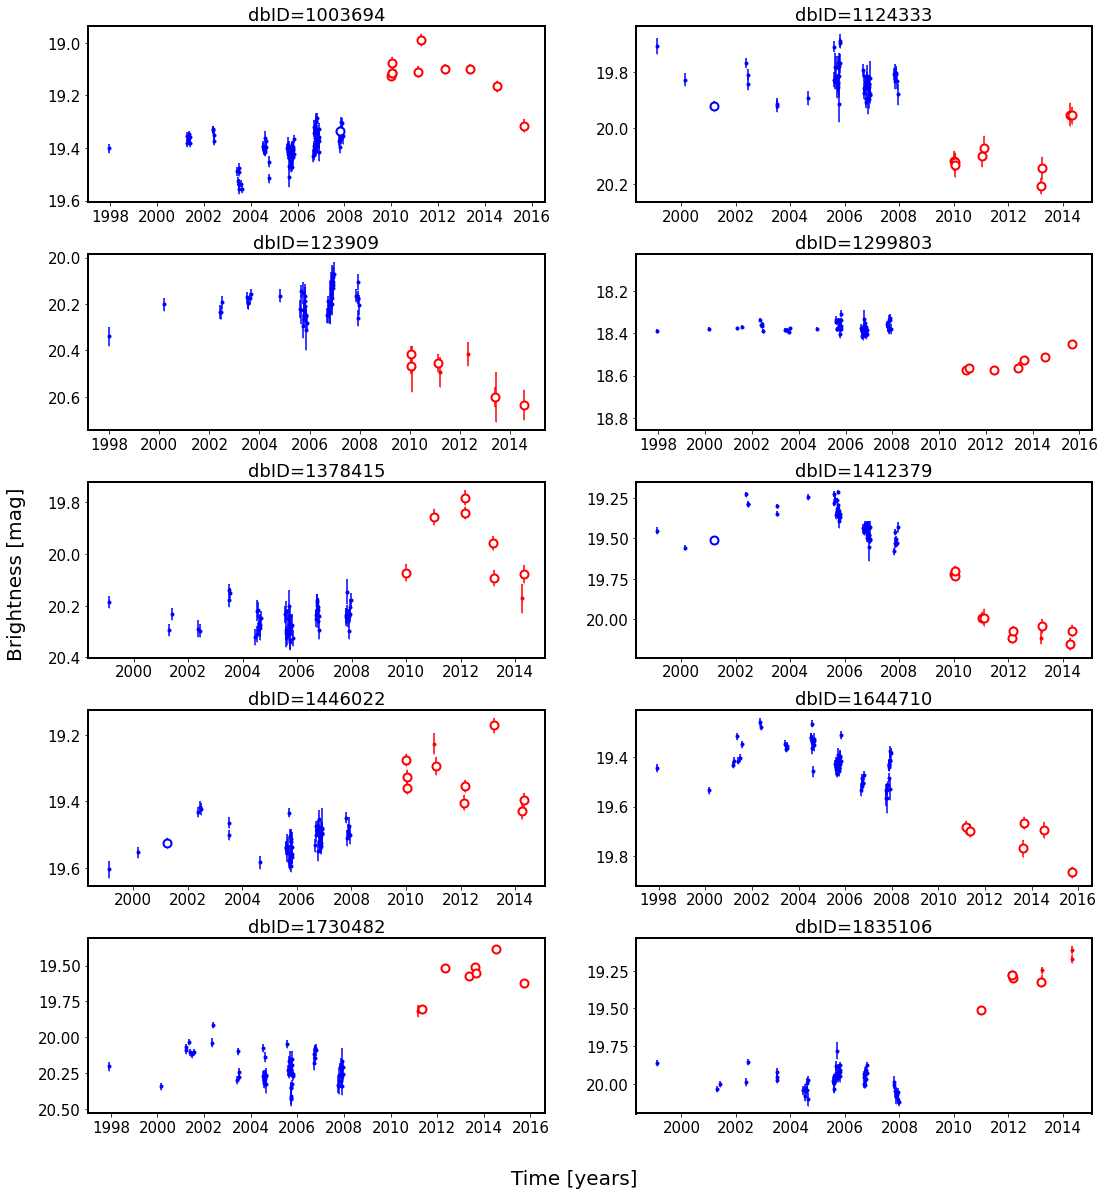

In [11]:
# Test the code on the set of CLQSO candidates that was 
# included in the submitted version of the paper ,
# i.e. that of December 2019, 
# which uses combined SDSS and PS1- based candidate 
# selection criterion 

date = '190807'
fname = '../code2/CLQSO_S82_candidates_'+date+'_data.npy'
ds = np.load(fname,allow_pickle=True)
page  = 0
print_lc_page_NEW(ds, page, 'test.png',)


## Compare various sets of CLQSO candidates <a id='compare_candidates'></a>

[toc](#toc)

In [271]:
# Read-in the Celerite results cross-matched with Shen2007 and 2011  databases (done in Compare_Celerite_Chelsea...)
date = '190807'#'190606'#'190807'#'190606'# '190807'
celerite = Table.read(date+'_Celerite_real_Jeff1_Shen2008-2011.txt',
                 format='ascii')

# Read the SDSS-PS1 offsets  calculated above,
# Using the light curves from ../dp2/real_sdss_ps1r_dr2_cleaned_NEW/
# that were used to calculate eg. 190807 results 
summary = Table.read('SDSS_PS1_DR2_cleaned_summary_NEW.txt', format='ascii') 

# join on lcname
data = join(celerite, summary, keys = 'lcname')


# select DRW outliers 
x = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'])
y = np.log10(data['tauEXP_sdss-ps1'] / data['tauEXP_sdss'])
m1 =  (y>1) & (x>0.4)

# add magnitude cutoff
#m2  = data['SDSSmedian']  < 20.5 
m2  = data['PS1median']  < 20.5
# combined masks 
m = m1 & m2
print(np.sum(m))

# store the subset with 38 candidates... 
data.rename_column('SDSS_NAME', 'SDSSJID')
data_clqso = data[m].copy()



41


In [212]:
# compare selecting sdss < 20.5  vs  ps1 < 20.5 
clqcans2_sdss = Table.read('CLQSO_S82_candidates_190807_SDSS.txt',
                          format='ascii')
clqcans2_ps1 = Table.read('CLQSO_S82_candidates_190807_PS1.txt',
                          format='ascii')

np.sum(np.in1d(clqcans2_sdss['lcname'], clqcans2_ps1['lcname']))

# well, 52 seem to be the same , so that's good ! 
# keep the intersection
common  = np.intersect1d(clqcans2_sdss['lcname'], clqcans2_ps1['lcname'])


# compare to the previous ones ... 
clqcans1 = Table.read('CLQSO_S82_candidates_190606.txt',format='ascii')
print(len(clqcans1))
np.sum(np.in1d(clqcans1['lcname'], common))

# 34 / 38 : that's pretty good ! 

# now the question is whether we want to add more cans, 
# to up the count to 52,  or not .... 

# I think it would be best to keep those that look nicest, and keep the number under 40, 
# so that the list fits on one page ... 

38


34

In [216]:
np.sum(clqcans2_ps1['PS1median'] < 20)

33

Splitting into  3  pages , with  10  objects per page


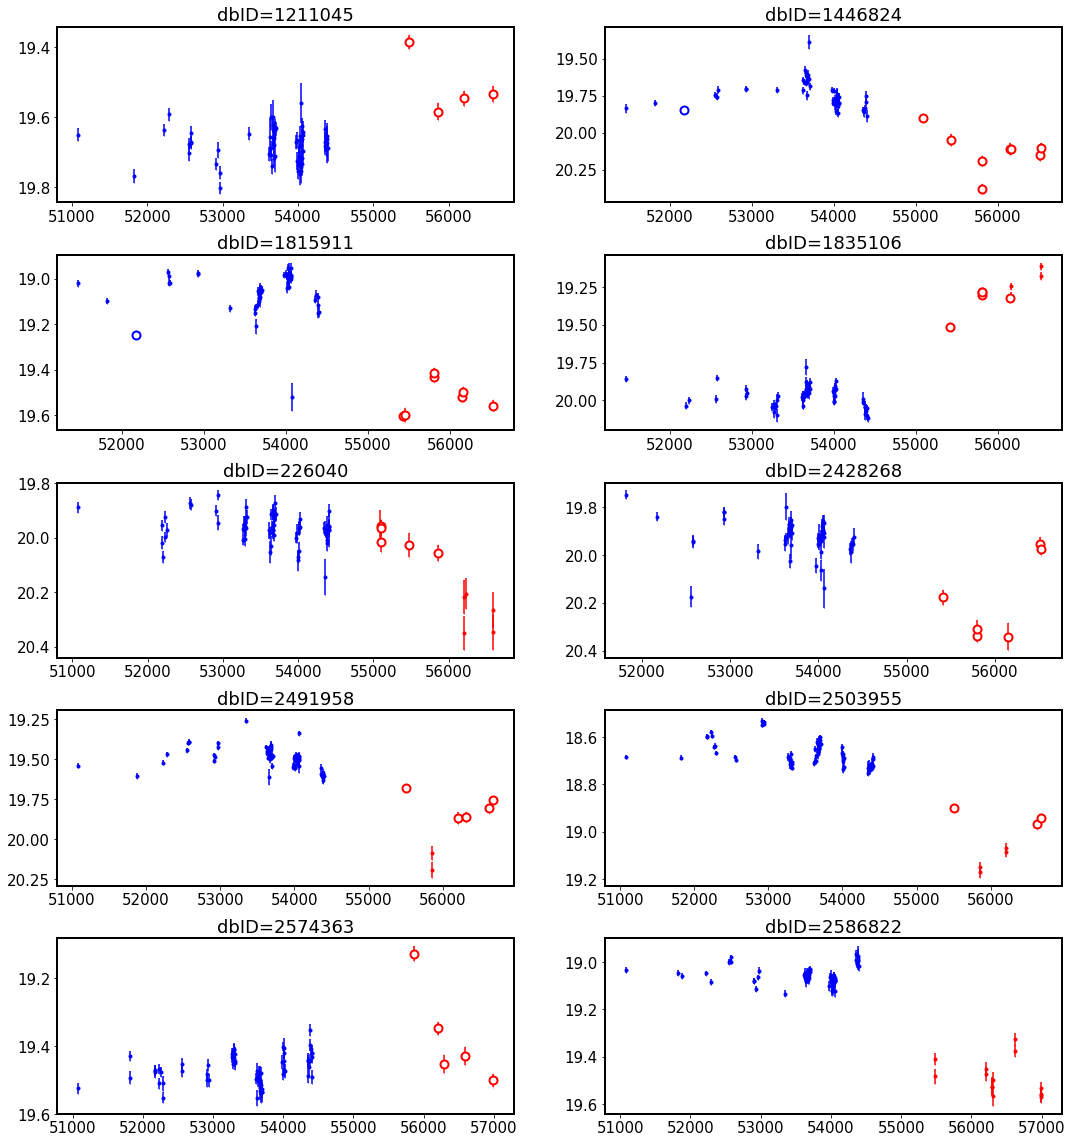

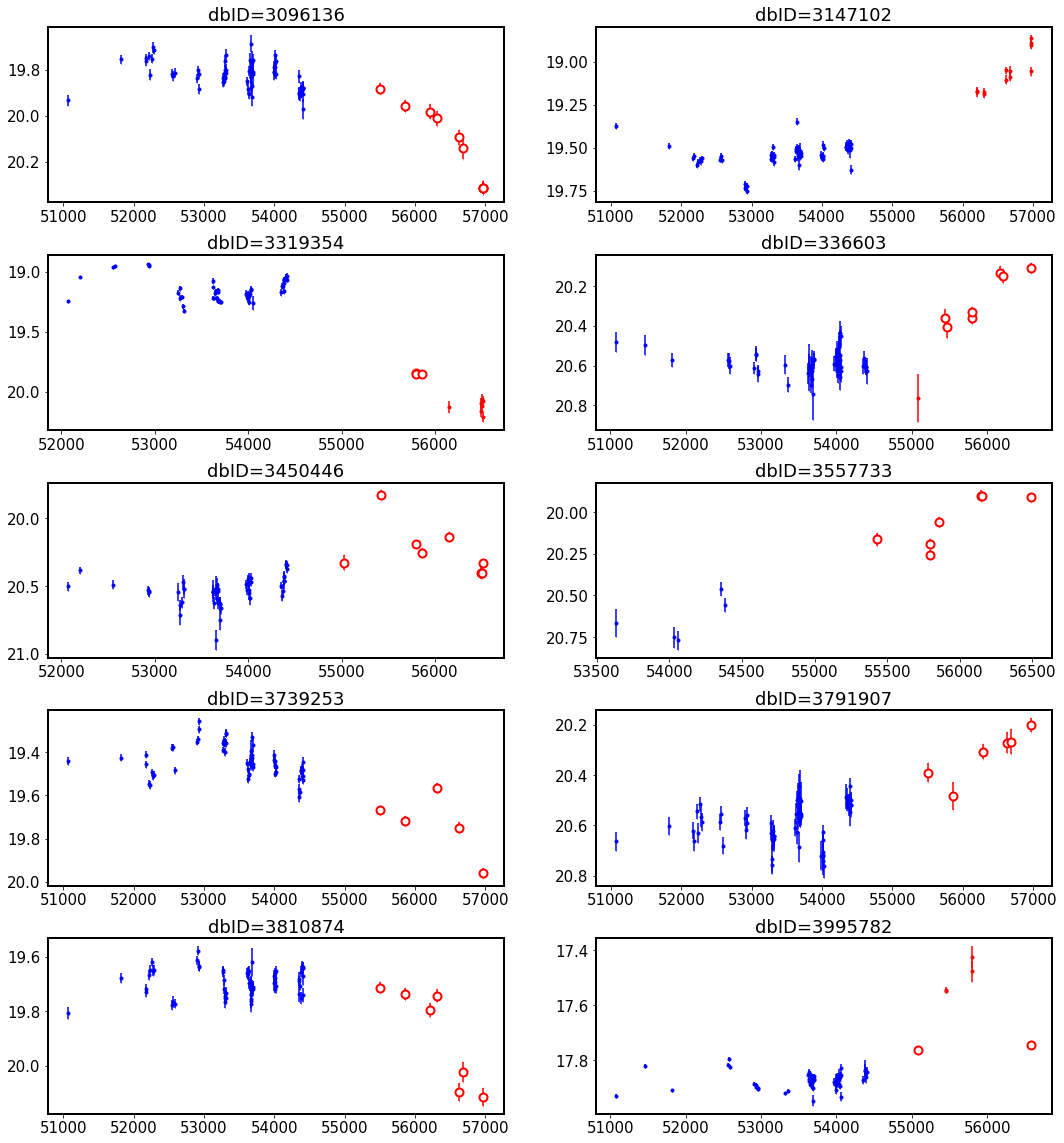

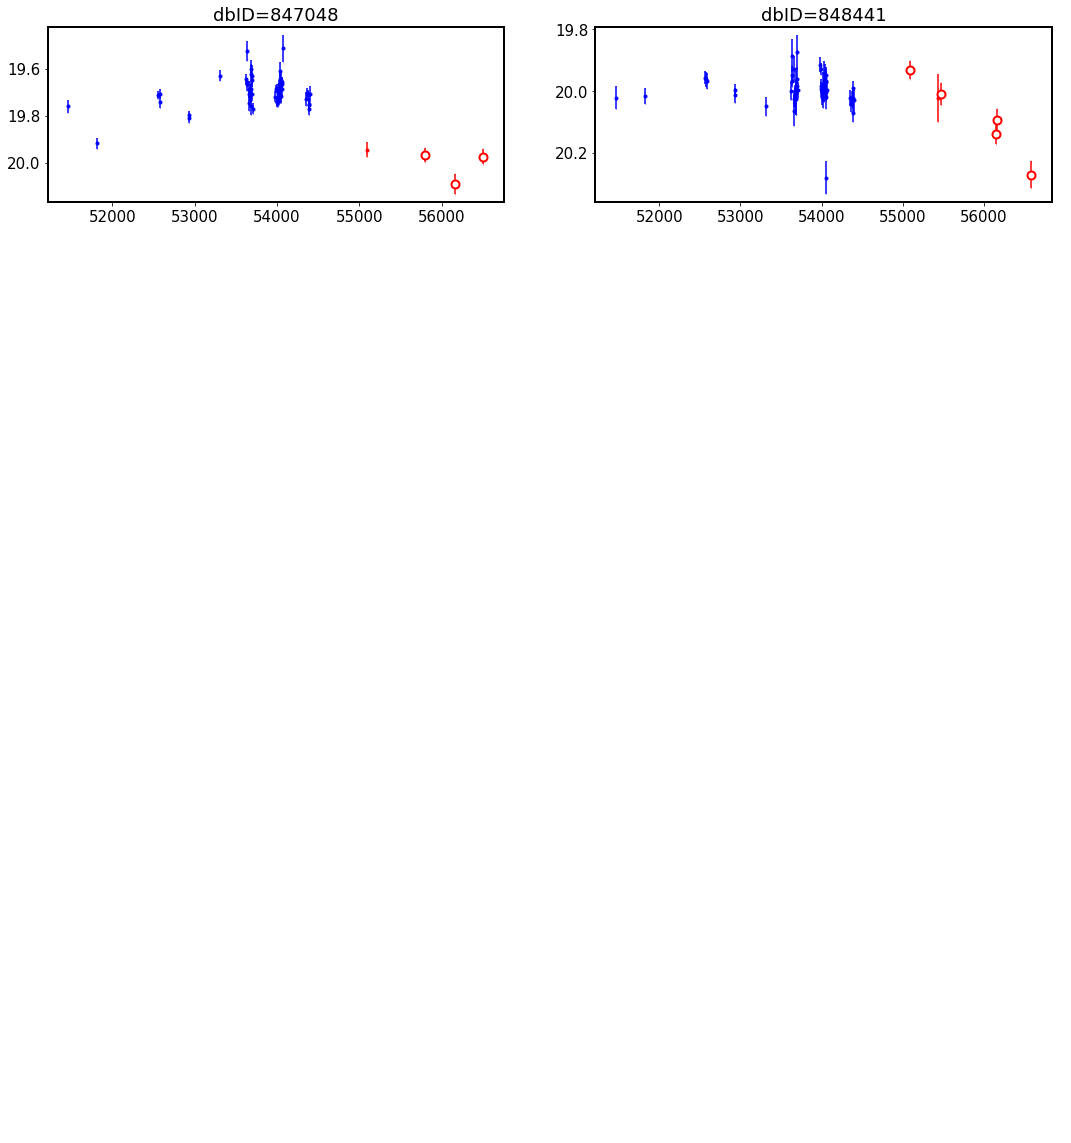

In [257]:
# plot just the new candidates based on 190807  cleaning ... 

#  do we get the same candidates in this search as before ? 
clqcans1 = Table.read('CLQSO_S82_candidates_190606.txt',format='ascii')
clqcans2 = Table.read('CLQSO_S82_candidates_190807_PS1.txt',format='ascii')

#np.sum(np.in1d(clqcans1['lcname'], clqcans2['lcname']))
# so 35/38 are in the larger 57 sources sample ... what are the ones
# that are new ? 

new = ~np.in1d(clqcans2['lcname'], clqcans1['lcname'])
clqcans2[new] # 22/57 are not in the other set .... 

data = clqcans2[new]

x = np.array(data)
NperPage = 10
Npages = (len(x) // NperPage)+1
print('Splitting into ', Npages , ' pages , with ', NperPage , ' objects per page')
indices_split = np.arange(NperPage,Npages*NperPage,NperPage)
ds = np.array_split(x,indices_split)

for  page in range(len(ds)) : 
    print_lc_page_NEW(ds, page, figname = 'clqcans_'+date+'_page_'+str(page)+'_N.png')

So after all deliberations, I just decided to stick to selecting those that are brighter than 20.5 in PS1 median magnitude (easier follow-up): that gives 56 candidates,  and selecting four pages (40) of those that have cleanest light curves. This overlaps with previous list of sources, only 3 being not included . 



In [16]:
# these have PS1 < 20.5 mag, 
# and tau, sigma fulfill the selection criterion 
clqcans2_ps1 = Table.read('CLQSO_S82_candidates_190807_PS1.txt',
                          format='ascii')
print(len(clqcans2_ps1))
clqcans1 = Table.read('CLQSO_S82_candidates_190606.txt',format='ascii')
print(len(clqcans1))
common_lcs  = np.intersect1d(clqcans2_ps1['lcname'], clqcans1['lcname'])
common_lcs_INT = [int(x[:-4]) for x in common_lcs]
print(len(common_lcs))

not_in_new_lcs = clqcans1['lcname'][~np.in1d(clqcans1['lcname'],common_lcs)]
print(not_in_new_lcs.data)

new_lcs = clqcans2_ps1['lcname'][~np.in1d(clqcans2_ps1['lcname'],clqcans1['lcname'])]
print(len(new_lcs))

# start from the clqso in common ... 
new_cans = common_lcs_INT

#  from the old list keep one qso that was well-observed 
keep_lcs = [612585]
new_cans.append(keep_lcs[0])

# remove some that are not great from the old set ,
# even though they overlap the new set 
remove_lcs = [3076365, 3219103, 3928645]
for x in remove_lcs:
        new_cans.remove(x)

# of the new ones, choose the best
add_lcs = [1835106, 2503955, 3096136, 3147102, 
           3319354, 3739253, 3810874,3791907]

for x in add_lcs:
    new_cans.append(x)

print(len(np.unique(new_cans)))

56
38
34
['2069362.txt' '307136.txt' '3916393.txt' '612585.txt']
22
40


In [17]:
values, counts = np.unique(new_cans,return_counts=True)
values[counts>1]

array([], dtype=int64)

In [18]:
# GRAB the data for the 40 candidates
# Read-in the Celerite results cross-matched with Shen2007 and 2011  databases 
# (done in Compare_Celerite_Chelsea...)
date = '190807' 
celerite = Table.read('../code2/'+date+'_Celerite_real_Jeff1_Shen2008-2011.txt',
                 format='ascii')

# Read the SDSS-PS1 offsets  calculated above,
# Using the light curves from ../dp2/real_sdss_ps1r_dr2_cleaned_NEW/
# that were used to calculate eg. 190807 results 
summary = Table.read('../code2/SDSS_PS1_DR2_cleaned_summary_NEW.txt', format='ascii') 

# join on lcname
data = join(celerite, summary, keys = 'lcname')

# rename the col
data.rename_column('SDSS_NAME', 'SDSSJID')

# store data for the 40 cans 
new_cans_TXT = [str(x)+'.txt' for x in new_cans]
data_clqso = data[np.in1d(data['lcname'], new_cans_TXT)]
print(len(data_clqso))
data_clqso.write('CLQSO_S82_40_candidates_'+date+'_PS1.txt', format='ascii',
                overwrite=True)

# split the table of 40 outliers into four sub arrays 
x = np.array(data_clqso)
NperPage = 10
Npages = (len(x) // NperPage)+1
print('Splitting into ', Npages , ' pages , with ', NperPage , ' objects per page')
indices_split = np.arange(NperPage,Npages*NperPage,NperPage)
ds = np.array_split(x,indices_split)

fname = 'CLQSO_S82_candidates_'+date+'_data'
print('Storing the partitioned sections of the data as ', 
     fname,'.npy')
np.save( fname, ds)




40
Splitting into  5  pages , with  10  objects per page
Storing the partitioned sections of the data as  CLQSO_S82_candidates_190807_data .npy


**Final version**  - the 40 candidates used in the submitted version of the paper  ( Nov 2019)

In [14]:
date = '190807'
fname = '../code2/CLQSO_S82_candidates_'+date+'_data.npy'
ds = np.load(fname,allow_pickle=True)

Print light curves for these objects 

Saved as fig22.pdf
Saved as fig23.pdf
Saved as fig24.pdf
Saved as fig25.pdf
Saved as fig26.pdf


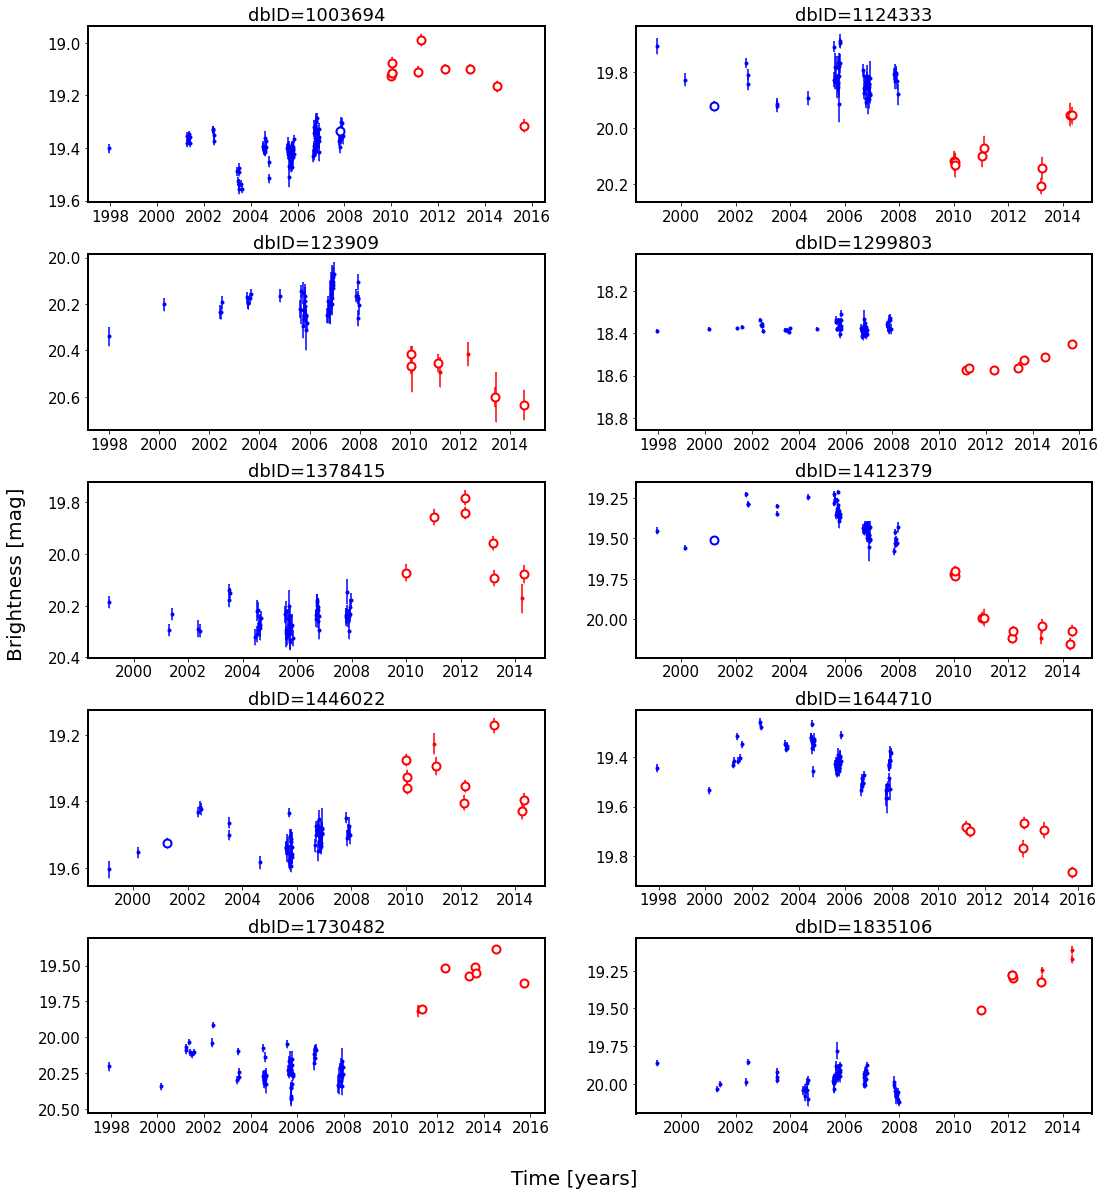

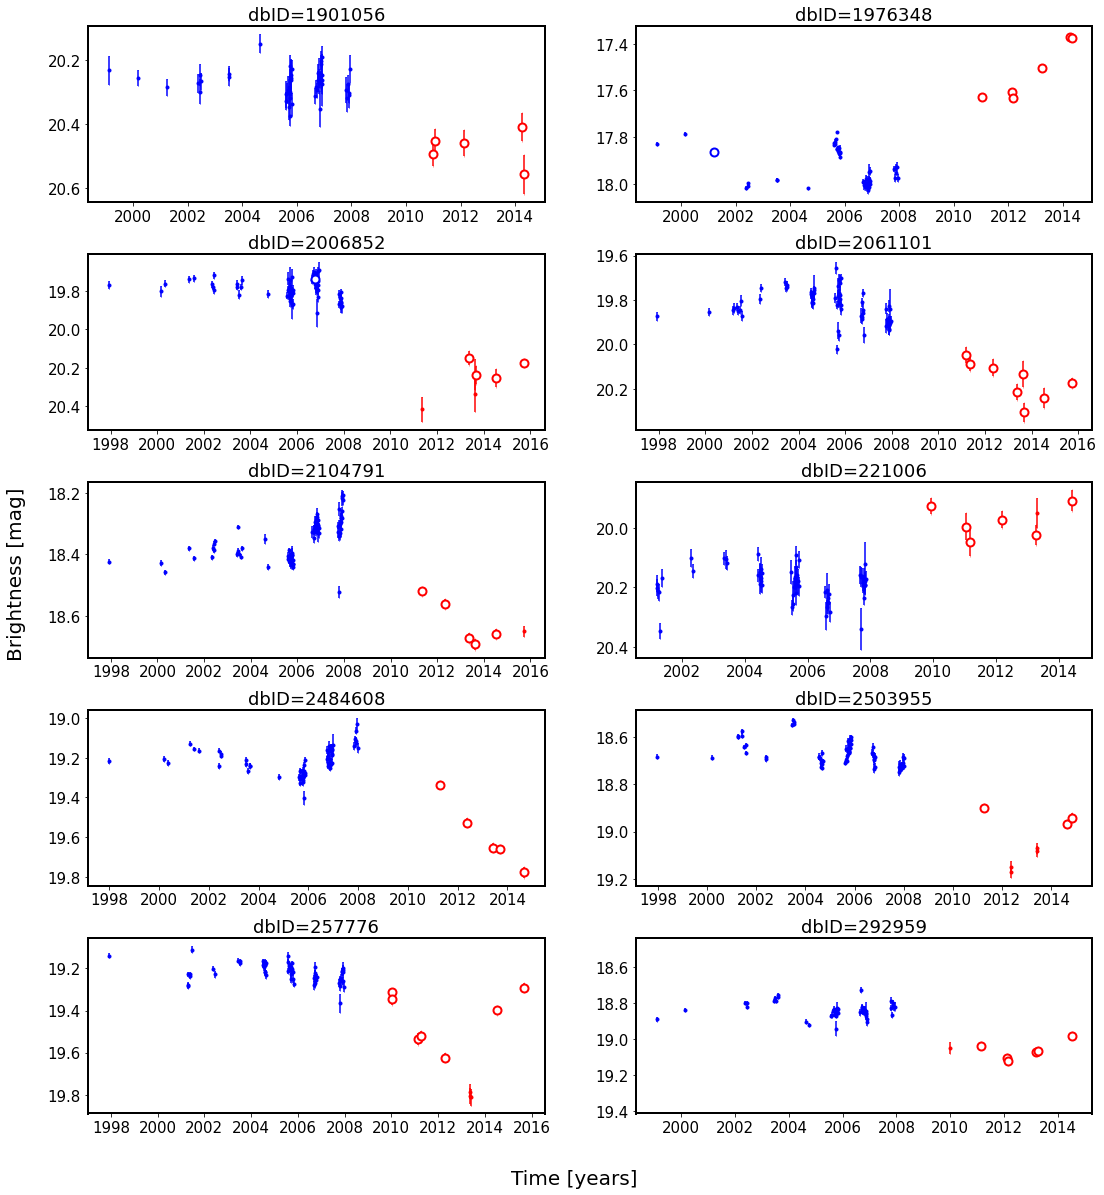

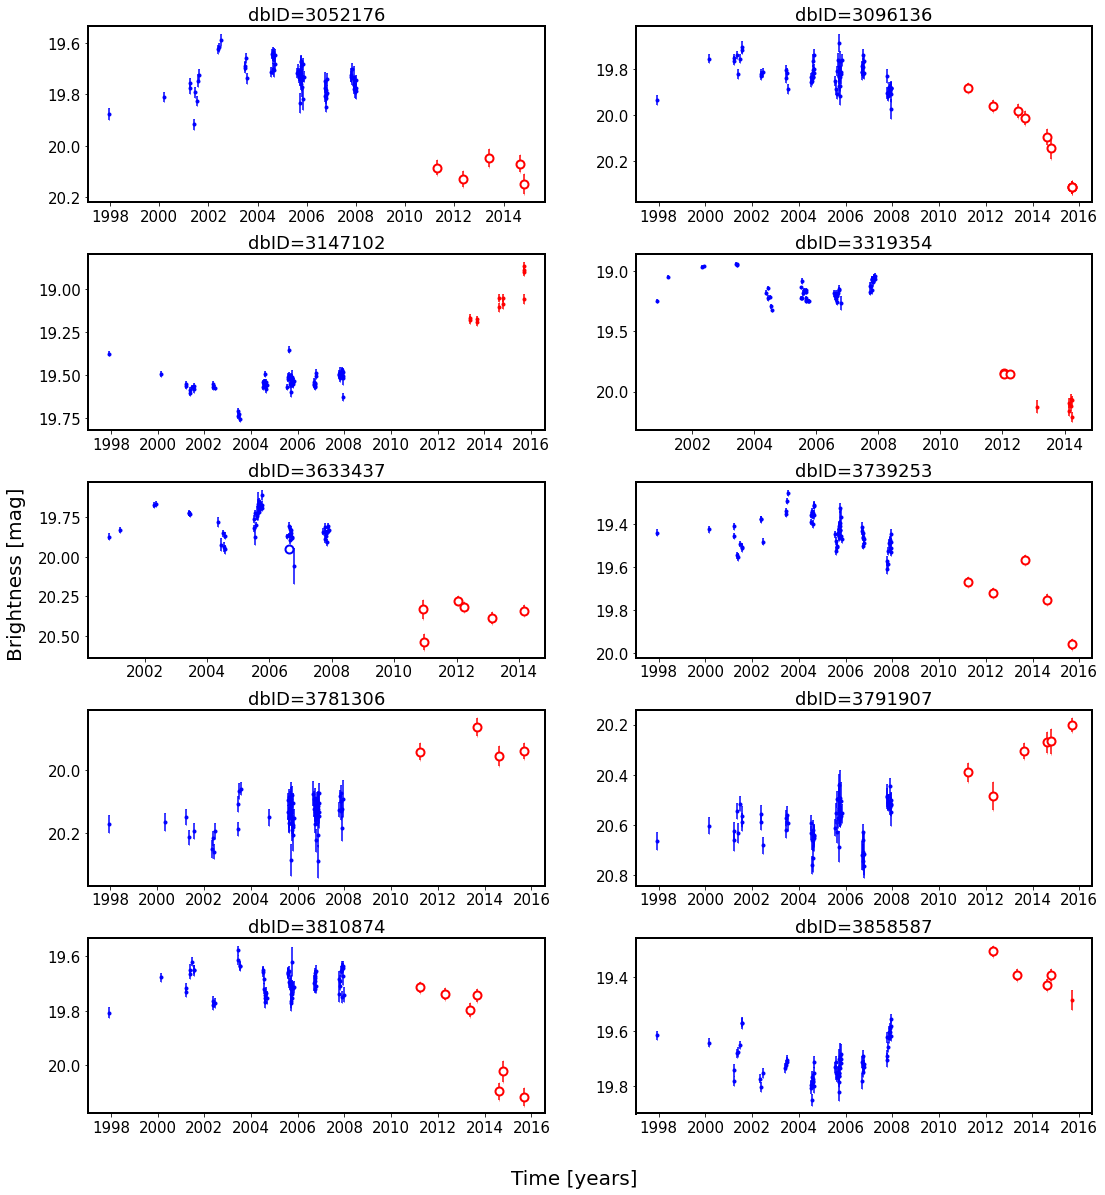

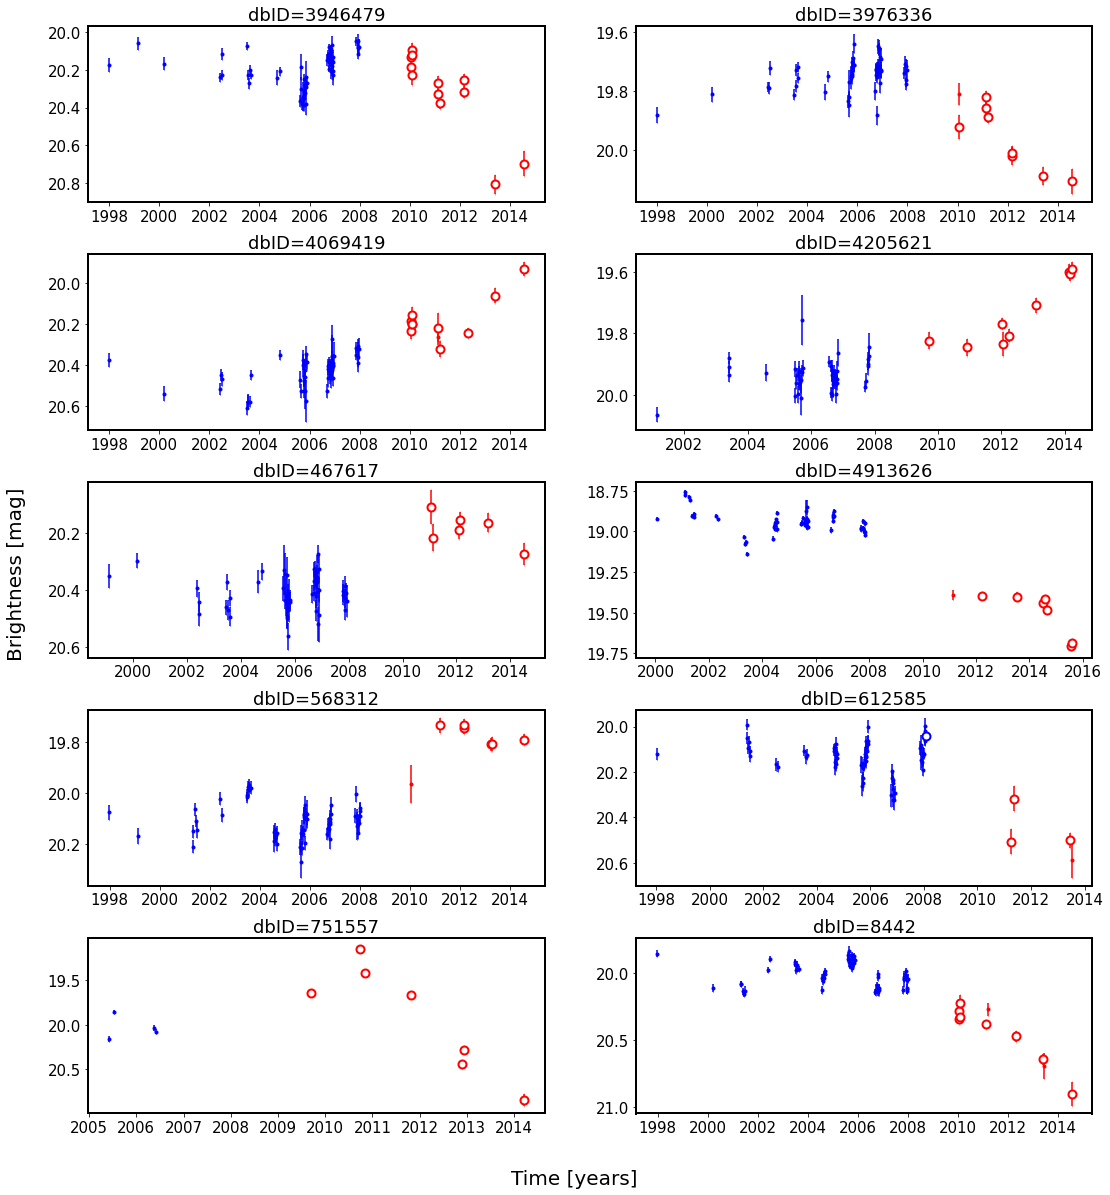

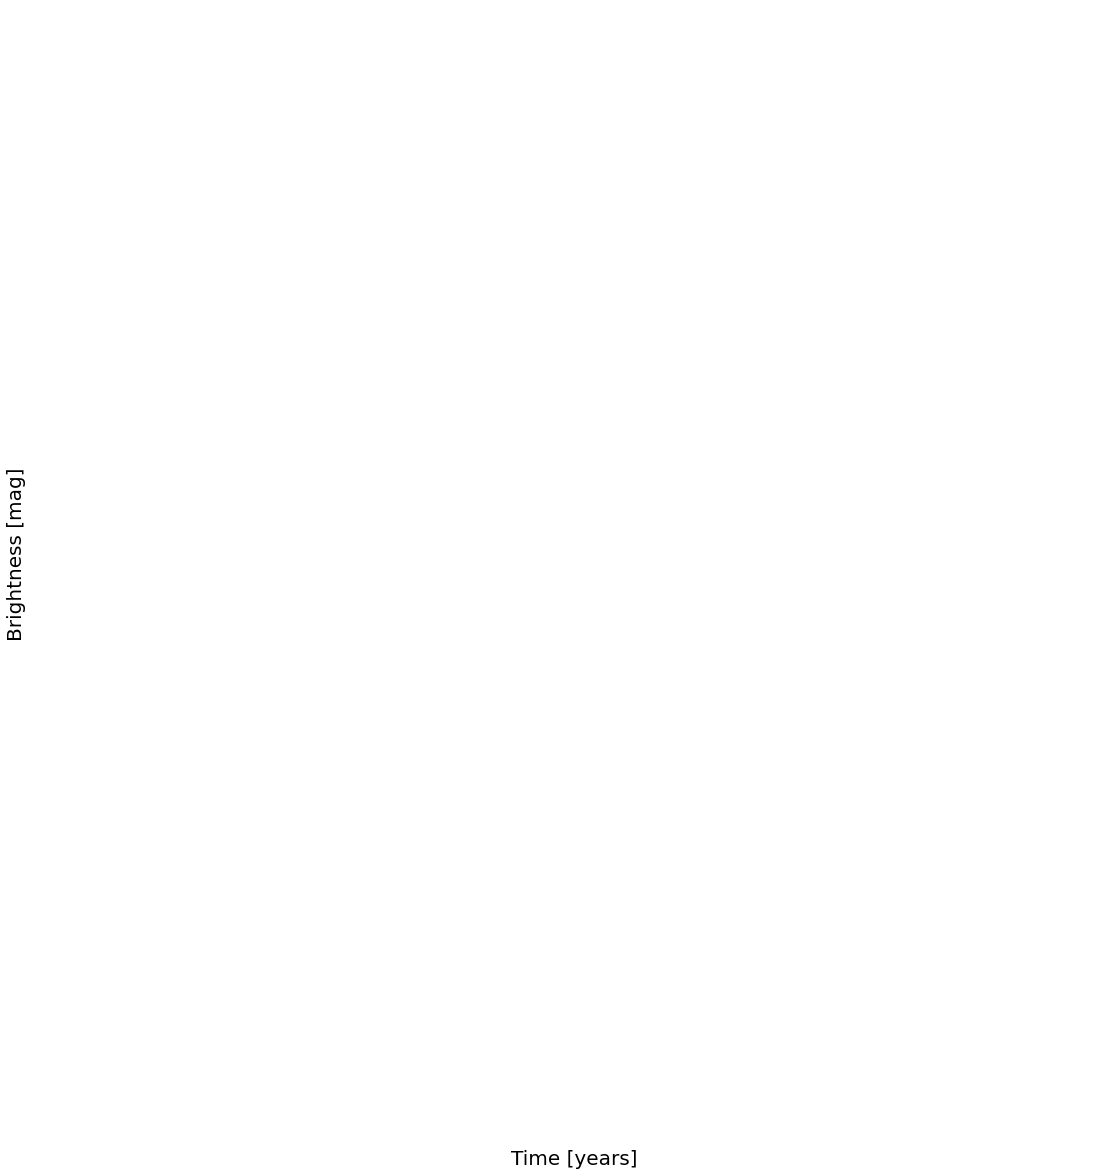

In [16]:
%matplotlib inline
for  page in range(len(ds)) : 
    print_lc_page_NEW(ds, page, figname = 'fig%d.pdf'%(22+page))

Plot just one light curve rather than a full page  ... 

'1003694.txt'

In [43]:
# edit away all not-used parts, eg. 
# - use only cleaned_NEW directory, 
# where lcs have a column with Nobs, so that we can 
# easily show which points were day-averaged (and which were not)
# - don't use other survey data 
import matplotlib.dates as mdates
from astropy.time import Time

def plot_clq_lc(dbID):
    #dbID = 751557
    lcname = str(dbID)+'.txt'
    figname = 'clqcan_dbID_'+str(dbID)+'.png'
    lcDir = '../dp2/real_sdss_ps1r_dr2_cleaned_NEW/'
    fig,ax = plt.subplots(1,1,figsize=(9,4))

    # plot the combined sdss - ps1 light curve, 
    lc = Table.read(lcDir+lcname, format='ascii')
    colors = ['blue','red']
    labels = ['SDSS r', 'PS1 DR2 r']

    j = 0 
    for s in ['sdss','ps1']:

        # plot what is kept in the cleaned light curve  - 
        # sdss, ps1 days with Nobs =1 , which are kept unchanged 
        rows = (lc['survey'] == s ) & (lc['Nobs'] == 1 )
        ax.errorbar(lc['mjd'][rows], lc['mag'][rows], 
                 lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
               c = colors[j])

        # and with a different color : days for which 
        # Nobs > 1, for which we find  avg mag  and avg err 
        rows = (lc['survey'] == s ) & (lc['Nobs'] > 1 )
        ax.errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                   fmt="o", capsize=0.2, markersize=8,
                 c = colors[j], mfc='white', mew=2 , label='')
        j += 1 

    ax.set_title('dbID='+lcname[:-4])
    ylim = ax.get_ylim()
    ymin, ymax =  min(ylim), max(ylim)
    span = ymax - ymin

    # increase the vertical span by  0.5 mag  if  less than 0.5 .... 
    min_span = 0.5
    if span  < min_span : 
        ymin_new = ymin - min_span / 2.
        ymax_new = ymax + min_span / 2.
        ax.set_ylim(ymin_new, ymax_new)

    ax.invert_yaxis()

    ########################################
    #### this code transforms mjd label to Year 
    #### by turning off the original axis and labels,
    #### and adding a new axis, moving it to the 
    #### position of the old axis, and formatting the
    #### labels as datetime. 
    ########################################

    # this turns off the labels 
    ax.get_xaxis().set_visible(False)

    # this turns off the axis line 
    ax.spines["bottom"].set_visible(False)

    # store xlims, ylims for the original axis 
    # the mjds are inferred as an array spanning
    # between the left and right limits of the 
    # original axis 
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()

    # make another x-axis with years ... 
    ax2 = ax.twiny()

    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")

    # Turn on the frame for the twin axis, but then hide all 
    # but the bottom spine
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    #for sp in ax2.spines.items():
    #    sp.set_visible(False)
    ax2.spines["bottom"].set_visible(True)
    #ax2.set_xlabel("Year")
    mjd = np.linspace(xlims[0], xlims[1], 10)
    t = Time(mjd, format='mjd')
    ax2.plot_date(t.datetime, np.zeros(len(t)), markersize=0)
    ax2.set_ylim(ylims)
    ax2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

    ########################################
    ########################################
    ax2.set_xlabel( 'Time [years]', fontsize=20)
    ax.set_ylabel('Brightness [mag]', fontsize=20)
    xticks = ax2.get_xticks()
    ax2.set_xticks(xticks[2:]) 
    plt.savefig(figname, bbox_inches='tight',
               dpi=100)

    print('Saved as %s'%figname)

Saved as clqcan_dbID_751557.png


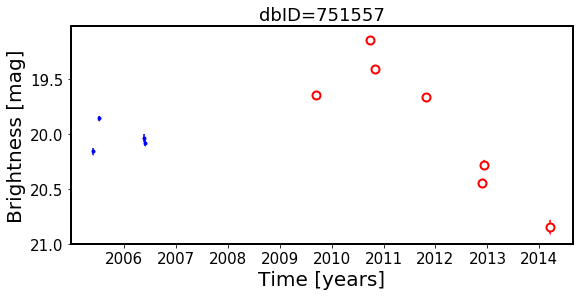

In [44]:
plot_clq_lc(751557)

Saved as clqcan_dbID_1003694.png


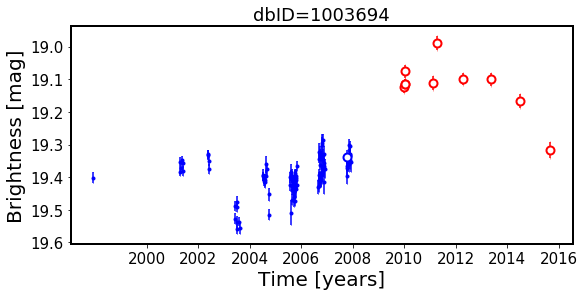

In [45]:
plot_clq_lc(1003694)

## Make a $\LaTeX$ Table <a id='latexTable'></a>

[toc](#toc)

Jump to [checking for info in various catalogs...](#check_info)

Save the info about CLQSO candidates  as $\LaTeX$ table 

In [32]:
import string 

# read the clqso cans table
d = Table.read('CLQSO_S82_40_candidates_190807_PS1.txt' , format='ascii',
              )#masked=False)
#d = Table.read('CLQSO_S82_38_candidates_FULL.txt', format='ascii')
d['deltaMag'] = d['SDSSmedian'] - d['PS1median']
d['deltaSigmaG'] = d['SDSSsigmaG'] - d['PS1sigmaG']

# sort by median PS1 mag ...
sortby = 'ra'# 'dbID'# PS1median' # dbID
d.sort(sortby)
#d.sort('dbID')

########################################
# ADD NOTES 
########################################

# Notes : letters a,b,c... 
letter_notes = {'1003694':['S82X \citep{lamassa2019}, WISE'],
         '1299803':['S82X \citep{lamassa2019}, WISE'],
         '751557':['M19, CLQSO candidate, Magellan follow-up'],
         '3633437':['In 3XMM-DR5 x-ray catalog \citep{rosen2016}'],
         '612585':['S82X \citep{lamassa2016a}, XMM Newton, Galex UV, UKIDSS, VHS, WISE']
        }

# notes:  symbol  "*"  
symbol_notes = {'1976348':['Recommended for follow-up'],
                '2104791':['Recommended for follow-up'],
                }

# rewrite contents of dict into two arrays
dbID_col = []
notes_col = []
for key in letter_notes.keys():
    dbID_col.append(key)
    notes_col.append(letter_notes[key])

# change arrays into cols of table 
notes_tab = Table(data=[dbID_col, notes_col], names=['dbID', 'Notes'],
                 dtype=['i4','S82'], masked=False)

# add indices that correspond to the correct order 
d['Index'] = np.arange(len(d))

# join the object notes with the object table,  to find out what 
# position in the object table corresponds to each object 
dt= join(d[['dbID', 'Index']],notes_tab, keys='dbID')
dt['Notes'] = dt['Notes'].astype(str)

# resort to the original order - this is the order in which 
# each object appears 
dt.sort('Index')

# loop over each dbID that has a lettered note 
# to be assigned 
db_to_assign = dt['dbID'].data
db_assigned = np.zeros(0)
letters  = list(string.ascii_lowercase)
j = 0 
dt['letters'] = ''
for db in db_to_assign : 
    if db not in db_assigned : 
        note = dt['Notes'][dt['dbID'].data == db][0]
        
        # test which rows correspond to that note
        note_rows = np.ravel(dt['Notes'].data == note)
        
        # assign that letter to all dbIDs with that note 
        dt['letters'][note_rows] = letters[j]
        
        # add these dbID(s) to a list of done objects 
        dbs = dt['dbID'][note_rows]
        db_assigned = np.append(dbs, db_assigned)

        # jump to next letter 
        j += 1
            
        
# at the very end, add symbol notes,  that do not need any particular order
for key in symbol_notes.keys():
    dt.add_row([int(key), 0, symbol_notes[key], '*'] ) 


# merge back with the main table 
#d = join(d,dt,keys='dbID', join_type='outer', )

# replace 0.0 and -999  missing values with NaN 
m = d['LOGBH']==0
d['LOGBH'][m] = None
d['LOGEDD_RATIO'][m] = None

# make them linked to CDS https://journals.aas.org/aastexguide/#deluxetable 
d['SDSSJID_CDS'] = ['\object[SDSS J'+x+']{'+x+'}' for x in d['SDSSJID']]    

#  change formatting to a LaTeX table ...
res = Table(data = [d['dbID'].astype('S60'),d['SDSSJID_CDS'], 
                    d['ra'].round(3), d['dec'].round(3),
                    d['REDSHIFT'].round(2),
                    d['LOGLBOL'].round(2), 
                    d['LOGBH'].round(2).astype(str), 
                    d['LOGEDD_RATIO'].round(2).astype(str),
                    d['deltaMag'].round(2),
                    d['deltaSigmaG'].round(3),
                    d['PS1median'].round(2),
                    ], 
            names = ['dbID', 'SDSSJID_CDS', 'ra','dec','REDSHIFT',
                    'LOGLBOL', 'LOGBH', 'LOGEDD_RATIO', 'deltaMag',
                     'deltaSigmaG', 'PS1median'
                     ])
# replace nan  with 'N/A' formatting  
m = res['LOGBH'] == 'nan'
res['LOGBH'][m] = 'N/A'
res['LOGEDD_RATIO'][m] = 'N/A'

# need to change the type 
# because for some odd reason,
# the S60 specification creates a bytes encoding 
# rather than a string ...
res['dbID'] = res['dbID'].astype(str)

#add tablenotemarks 
for row in range(len(dt)):
    m = res['dbID'] == str(dt[row]['dbID'])
    old = res['dbID'][m].data[0]
    new = old + r'\tablenotemark{%s}'%dt[row]['letters']
    res['dbID'][m] = new
    
# change colnames # need to escape the backslash...
# old_new_colnames = {'dbID': '\colhead{dbID}',
#                     'SDSSJID_CDS':'\colhead{SDSSJID}',
#           'ra':'\colhead{$\\alpha$}', 'dec':'\colhead{$\delta$}',
#           'REDSHIFT':'\colhead{redshift}',
#           'LOGLBOL':'\colhead{$\log_{10}{(L_{Bol})}$}',
#           'LOGBH':'\colhead{$\log_{10}{(M_{\mathrm{BH}}/ M_{\odot})}$}',
#           'LOGEDD_RATIO':'\colhead{$f_{Edd}$}',
#           'deltaMag':'\colhead{$\Delta(\mathrm{mag})$}',
#           'deltaSigmaG':'\colhead{$\Delta(\sigma_{G})$}',
#          'PS1median':'\colhead{median PS1}'
#           }
# for key in old_new_colnames.keys() : 
#     res.rename_column(key, old_new_colnames[key])


#res.write(fname,  format='latex', overwrite=True)

# make a copy of the table where we only keep one note per letter
#du = unique(dt, keys='letters')

# Add to that table the footnotes that explain the letter
# f = open(fname, 'a')
# for i in range(len(du)):
#     letter = du[i]['letters'][0]
#     note = du[i]['Notes'][0]
#     s = r'\tablenotetext{\tiny %s}{%s}'%(letter, note)
#     f.write(s+'\n')

# f.close()


Saved the Table2 as CLQSO_S82_40_candidates_190807_PS1_latex_ra.txt


Use this custom-written routine to save the table as deluxetable, in case any changes were required... This means that I don't need to take the column names and the data and change `\table` and `\tabular` to `\deluxetable` manually... '. **NOTE** : it also copies this file to `\report\table_appendix.tex` so that whatever was the table it gets **overwritten**&! 

In [66]:
# # need to escape the backslash in column names 
old_new_colnames = {'dbID': '\\colhead{dbID}',
                    'SDSSJID_CDS':'\\colhead{SDSSJID}',
          'ra':'\\colhead{$\\alpha$}', 
          'dec':'\\colhead{$\\delta$}',
          'REDSHIFT':'\\colhead{redshift}',
          'LOGLBOL':'\\colhead{$\\log_{10}{(L_{Bol})}$}',
          'LOGBH':'\\colhead{$\\log_{10}{(M_{\\mathrm{BH}}/ M_{\\odot})}$}',
          'LOGEDD_RATIO':'\\colhead{$f_{Edd}$}',
          'deltaMag':'\\colhead{$\\Delta(\\mathrm{mag})$}',
          'deltaSigmaG':'\\colhead{$\Delta(\\sigma_{G})$}',
         'PS1median':'\\colhead{median PS1}'
          }

fname = 'CLQSO_S82_40_candidates_190807_PS1_latex_'+sortby+'.txt'
f = open(fname, 'w')

# write beginning 
s = '\\begin{deluxetable*}{c' +'|' +'C'*(len(res.colnames)-1)+'}\n'
f.write(s) 

# write caption
s = '\\tablecaption{CLQSO candidates : catalog information from \\cite{shen2011}, concerning DR7 name (dbID) and SDSSJID location ($\\alpha$, $\\delta$ in degrees, J2000), distance (spectrum-based redshift),  physical parameters (bolometric luminosity  $L_{Bol}$ erg s$^{-1}$, black hole mass $M_{\\mathrm{BH}}/ M_{\\odot} $, Eddington ratio $f_{Edd} = L_{Bol} / L_{Edd}$),  and light curve properties (the difference between median SDSS and PS1 magnitudes $\\Delta(\\mathrm{mag})$, the difference in scatter between SDSS and PS1 segments $\\Delta(\\sigma_{G})$, and the median PS1 magnitude  - see Fig.~\\ref{fig:median_offsets}). \\label{tab:clqso}}\n' 
f.write(s) 

# write column names 
a = '\\tablehead{'
for x in res.colnames:
    a += old_new_colnames[x] + ' & '
a = a[:-2] # remove the trailing &
a += '}\n'
f.write(a)

# mark the beginning of data
f.write('\\startdata \n')

# write row by row table content 
for row in range(len(res)):
    a = ''
    for x in res[row]:
        a += str(x)+' & '
    a = a[:-2]
    a += '\\\ \n'
    f.write(a)

# mark the end of data
f.write('\\enddata \n')

# write to  file the table note text 
# make a copy of the table where we only keep one note per letter
du = unique(dt, keys='letters')

for i in range(len(du)):
    letter = du[i]['letters'][0]
    note = du[i]['Notes'][0]
    s = '\\tablenotetext{\\tiny %s}{%s}'%(letter, note)
    f.write(s+'\n')
    
# end the table 
a = '\\end{deluxetable*}'
f.write(a)
f.close()

print('Saved the Table2 here (/code2/) as %s'%fname)

# move that over to the report ... 
!cp $fname ../report/table_appendix.tex
print('And moved to ../report/ as table_appendix.tex' )

Saved the Table2 here (/code2/) as CLQSO_S82_40_candidates_190807_PS1_latex_ra.txt
And moved to ../report/ as table_appendix.tex


# Automatically assigning alphabet letters to object footnotes in a data table <a id='assign_letters'></a>

[toc](#toc)

Minimal working example for the future ... 

In [483]:
import string
from astropy.table import Table
import numpy as np

# Assume we have  a list of objects, each object with some properties 
objIds = [111,222,333,444,555,566]
mag = [14,15,6,21,26,22]
magerr = [0.1, 0.2, 0.01, 0.2,0.4,0.01]

# so we have an AstroPy Table with these properties 
d = Table(data = [objIds, mag, magerr], names=['dbID', 'mag', 'magerr'])


# sort by desired property 
d.sort('mag')

# add indices that correspond to the correct order 
d['Index'] = np.arange(len(d))


# assume we have a dictionary of notes for certain objects 
# where the key corresponds to object id 
notes = {111 : 'see Suberlak2019',
        222: 'ignore',
        444:'see Suberlak2019', 
        333 : 'other'}

# rewrite the dict to a table 
dbID_col = []
notes_col = []
for key in notes.keys():
    dbID_col.append(key)
    notes_col.append(notes[key])

# change arrays into cols of table 
notes_tab = Table(data=[dbID_col, notes_col], names=['dbID', 'Notes'],
                 dtype=['i4','S82'])


# join the object notes with the object table,  to find out what 
# position in the object table corresponds to each object 
dt= join(d,notes_tab, keys='dbID')
dt['Notes'] = dt['Notes'].astype(str)

# resort to the original order - this is the order in which 
# each object appears , in case it got lost while join 
dt.sort('Index')


# make a list to store those 
# object dbIds that have already been assigned 
# a letter 
db_assigned = np.zeros(0)

# automatically create a list of letters of alphabet 
letters  = list(string.ascii_lowercase)

j = 0 
# initiate a column for footnote letters 
dt['letters'] = ''

# iterate over objects 
for db in dt['dbID'].data : 
    if db not in db_assigned : 
        
        # extract note corresponding to that object 
        note = dt['Notes'][dt['dbID'].data == db][0]
        
        # test which rows correspond to that note
        note_rows = np.ravel(dt['Notes'].data == note)
        
        # assign that letter to all dbIDs with that note 
        dt['letters'][note_rows] = letters[j]
        
        # add these dbID(s) to a list of done objects 
        dbs = dt['dbID'][note_rows]
        db_assigned = np.append(dbs, db_assigned)

        # jump to next letter 
        j += 1
            
# the result : 
print(dt)

dbID mag magerr Index      Notes       letters
---- --- ------ ----- ---------------- -------
 333   6   0.01     0            other       a
 111  14    0.1     1 see Suberlak2019       b
 222  15    0.2     2           ignore       c
 444  21    0.2     3 see Suberlak2019       b


In [319]:
# find out in what order do they appear in the sorted table 
# (as it would be in the latex table)
d.sort('PS1median')



ids_table = Table(data=[list(notes.keys), list(notes.items)], names=['dbID', 'Notes'])
ds= join(d,ids_table, keys='dbID' )
ds

TypeError: 'builtin_function_or_method' object is not iterable

In [304]:
Table.from_d

array([1003694, 1299803,  751557, 3633437,  612585, 1976348, 2104791])

In [43]:

# change colnames 
old_new_colnames = {'dbID': '\colhead{dbID}',
                    'SDSSJID_CDS':'\colhead{SDSSJID}',
          'ra':'\colhead{$\alpha$}', 'dec':'\colhead{$\delta$}',
          'REDSHIFT':'\colhead{redshift}',
          'LOGLBOL':'\colhead{$\log_{10}{(L_{Bol})}$}',
          'LOGBH':'\colhead{$\log_{10}{(M_{\mathrm{BH}}/ M_{\odot})}$}',
          'LOGEDD_RATIO':'\colhead{$f_{Edd}$}',
          'deltaMag':'\colhead{$\Delta(\mathrm{mag})$}',
          'deltaSigmaG':'\colhead{$\Delta(\sigma_{G})$}',
         'PS1median':'\colhead{median PS1}'
          }
for key in old_new_colnames.keys() : 
    res.rename_column(key, old_new_colnames[key])
    

res.write('CLQSO_S82_40_candidates_190807_PS1_latex.txt', 
          format='latex', overwrite=True)

# add notes about specific objects ... 


# tablenotetext  = 
# tableobject = ['751557', '612585', ['1003694', '1299803']]

# d['Notes'] = np.zeros_like(d['SDSSJID'], dtype='S60')
# otherData = {'751557':'M19, CLQSO candidate, Magellan follow-up',
#             '612585':'S82X LaMassa2016, XMM Newton, Galex UV, UKIDSS, VHS, WISE',
#             '1003694': 'S82X LaMassa2019, WISE',
#             '1299803': 'S82X LaMassa2019, WISE'}





    

## Check for info about candidates in various sources <a id='check_info'></a>

[toc](#toc)

In [5]:
# Read in the clqso candidates table
d = Table.read('CLQSO_S82_40_candidates_190807_PS1.txt' , format='ascii')
d.sort('dbID')

In [228]:

d[d['dbID'] == 123909]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,SDSSJID,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,deltaMag,deltaSigmaG,Index,SDSSJID_CDS
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str53
123909.txt,3321.0339959999983,0.0440324407124872,0.03892609863320452,84.59344148686787,24.446567578132278,5506.0793299,0.18107774794462045,0.14862677785045558,2128.709898573251,1112.0823342299614,123909,4.110588,0.609013,587,-26.398,-26.744,3.2262,0.0,0.0,23.049,20.61,20.305,20.083,20.099,0.118,001626.54+003632.4,4.110591888427734,0.609013020992279,3.23799991607666,46.56739073644744,9.469865226899438,0.44912462924033775,-1.0028450355695568,-26.856009133655892,0.10747569523956114,20.48146572800598,0.05374425000000116,20.194499999999998,-0.2869657280059812,-0.053731445239559986,38,\object[SDSS J001626.54+003632.4]{001626.54+003632.4}


Check out Chelsea's  data for these QSO ... Her X-ray data could be useful - but while she's on vacations, check out Stephanie LaMassa  S82X  catalog .... 

In [16]:
# First, read in the tab2.txt from MAcLeod+2019 

In [8]:
tab2 = Table.read('tab2.txt', names = ['SDSSJID','z', 'morph.flag', 'Phot.MJD_1',
'g_1' , 'sigma_1' , 'Phot.MJD_2', 'g_2', 'sigma_2' , 'Spec.MJD_1', 
'MJD(PS1)',  'g_PS1', 'sigma_PS1',  'Spec.MJD_2', 'Facility', 'CLQbyVI?', 
                                      'N_sigma(Hbeta)'],   format='ascii')

dt = join(d, tab2, keys='SDSSJID')

In [9]:
dt

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z_1,Au,SDSSJID,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,z_2,morph.flag,Phot.MJD_1,g_1,sigma_1,Phot.MJD_2,g_2,sigma_2,Spec.MJD_1,MJD(PS1),g_PS1,sigma_PS1,Spec.MJD_2,Facility,CLQbyVI?,N_sigma(Hbeta)
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,int64,float64,float64,int64,str8,int64,float64
751557.txt,332.0341600000029,0.13189540957061696,0.09421540070824395,7.6794103981489314,0.09999999999999998,2918.1116526999976,0.4728961823435043,0.4378389334915244,306.6854273674961,0.09999999999999998,751557,343.168213,1.166308,75199,-22.552,-22.857,0.5339,0.0,0.0,20.979,20.382,20.312,19.813,19.648,0.408,225240.37+010958.7,343.1682434082031,1.1663060188293457,0.5335999727249146,45.31824592746787,8.87780333233864,0.1719575736913289,-1.6599279499883366,-23.00210046367719,0.6168260291426754,19.668917131040367,0.08061637499999778,20.057499999999997,0.534,0,51464,21.271,0.054,55446,19.207,0.02,55500,56575,21.001,0.082,57598,Magellan,1,3.7


Saved as  SDSS_PS1_DR2_combined_lc_751557.png


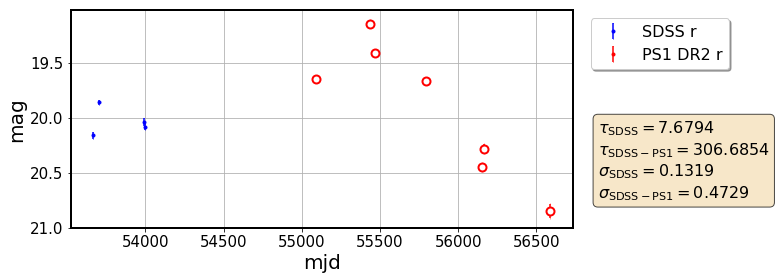

In [247]:
# SDSSJID = 225240.37+010958.7 
lc = plot_SDSS_PS1_single('751557.txt')

Only this QSO appears in Chelsea's list. Let's check against the other list : 

In [10]:
a = 'SDSSJID, ra, dec, z, morph_flag,  mjd1, g1, ge1, mjd2, g2, ge2, Nspec, MJDlast_spec, MJDlast_phot, g_last_phot, ge_last_phot, obsflag, FESflag, FEStargflag, Nicflag, Ianflag, CLQflag, Selection, Priority, Observatory, MJDfollowup1, MJDfollowup2, CSSflag, robustflag, radioflag, reobs, rebright'
b = a.split(sep=',')
c = [x.strip() for x in b] 
clqcans = Table.read('clqcans.dat', names = c, format='ascii')
dc  = join(d, clqcans, keys='SDSSJID')
dc

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra_1,dec_1,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z_1,Au,SDSSJID,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,ra_2,dec_2,z_2,morph_flag,mjd1,g1,ge1,mjd2,g2,ge2,Nspec,MJDlast_spec,MJDlast_phot,g_last_phot,ge_last_phot,obsflag,FESflag,FEStargflag,Nicflag,Ianflag,CLQflag,Selection,Priority,Observatory,MJDfollowup1,MJDfollowup2,CSSflag,robustflag,radioflag,reobs,rebright
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,str15,int64,int64,int64,str17,int64,str13,int64,int64,int64,int64,int64,int64,int64
751557.txt,332.0341600000029,0.13189540957061696,0.09421540070824395,7.6794103981489314,0.09999999999999998,2918.1116526999976,0.4728961823435043,0.4378389334915244,306.6854273674961,0.09999999999999998,751557,343.168213,1.166308,75199,-22.552,-22.857,0.5339,0.0,0.0,20.979,20.382,20.312,19.813,19.648,0.408,225240.37+010958.7,343.1682434082031,1.1663060188293457,0.5335999727249146,45.31824592746787,8.87780333233864,0.1719575736913289,-1.6599279499883366,-23.00210046367719,0.6168260291426754,19.668917131040367,0.08061637499999778,20.057499999999997,343.16823,1.166306,0.534,0,51464.0,21.271,0.054,55446.5,19.207,0.02,3,55500.0,56575.4,21.001,0.082,1,0,N/A,0,0,1,Public,5,MMT2017C,57598,58037,0,0,0,0,0


It's the same one ! 

Finally, let's check against the list from Tab3 in MacLeod+2016, that includes single CLQSOs found by Ruan2015, Runnoe2015, and LaMassa2015 

In [11]:
tab3_macleod16 = ['012648.08−083948.0', '015957.64+003310.4', '101152.98+544206.4',
                 '233602.98+001728.7']
np.in1d(d['SDSSJID'], tab3_macleod16)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

Neither! So at least those that I have found are not the orinally claimed discoveries. 

Also, check against Table2 in MacLeod2016 : newly discovered CLQSO with changing BEL 

In [12]:
# nicely, her source just includes the table as a separate file 
tab2_m16 = Table.read('table_of_CLQs_MNRAS.tex', format='latex'
                    )
tab2_m16.rename_column('Name', 'SDSSJID')

cm = join(d, tab2_m16, keys='SDSSJID')

In [8]:
#data_clqso  = Table.read('CLQSO_S82_38_candidates_FULL.txt', format='ascii')

In [13]:
cm

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,SDSSJID,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,$z$,Max($\Delta g$),$\Delta t_{\rm RF}$,BEL,$({\rm MJD|plate|fiber})_{\rm 1}$,$({\rm MJD|plate|fiber})_{\rm 2}$,$|\Delta f_\nu| \propto \nu^\beta$
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str17,int64,str9,str17,str17,str33
751557.txt,332.0341600000029,0.13189540957061696,0.09421540070824395,7.6794103981489314,0.09999999999999998,2918.1116526999976,0.4728961823435043,0.4378389334915244,306.6854273674961,0.09999999999999998,751557,343.168213,1.166308,75199,-22.552,-22.857,0.5339,0.0,0.0,20.979,20.382,20.312,19.813,19.648,0.408,225240.37+010958.7,343.1682434082031,1.1663060188293457,0.5335999727249146,45.31824592746787,8.87780333233864,0.1719575736913289,-1.6599279499883366,-23.00210046367719,0.6168260291426754,19.668917131040367,0.08061637499999778,20.057499999999997,0.534,$-2.06 \pm 0.06$,2596,Appear,$52174|0676|0442$,$55500|4294|0045$,$-0.45 \pm 0.08 $


So the overlap is the same QSO that was mentioned in MacLeod2019 (SDSSJID 225240.37+010958.7  ) 

Let's find out if there's any data for these in LaMassa2016 or LaMassa2019 catalogs... 

In [14]:
chandra = Table.read('/Users/chris/Downloads/Chandra_multiwavelength_new_spectra.fits', 
                     format='fits')
#chandra['SDSS_RA', 'SDSS_DEC']

# remove those rows that do not have SDSS counterparts
chandra.remove_rows(chandra['SDSS_RA'] < -200)


cat1 = SkyCoord(ra=d['RA']*u.degree, dec=d['DEC']*u.degree)
cat2 = SkyCoord(ra=chandra['SDSS_RA']*u.degree,dec=chandra['SDSS_DEC']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 

data_clqso_chandra = hstack([d, chandra[idx]])
data_clqso_chandra['sep2d_asec'] = sep2d.arcsec

# select those that have a match within eg. 10 asec ...
m = data_clqso_chandra['sep2d_asec'] < 20
data_clqso_chandra[m]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,SDSSJID,RA_1,DEC_1,REDSHIFT_1,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,MSID,OBSID,RA_2,DEC_2,RADEC_ERR,DIST_NN,IN_XMM,IN_XMM_AO13,REMOVED_LOGN_LOGS,SOFT_FLUX,SOFT_FLUX_ERROR_HIGH,SOFT_FLUX_ERROR_LOW,SOFT_COUNTS,HARD_FLUX,HARD_FLUX_ERROR_HIGH,HARD_FLUX_ERROR_LOW,HARD_COUNTS,FULL_FLUX,FULL_FLUX_ERROR_HIGH,FULL_FLUX_ERROR_LOW,FULL_COUNTS,LUM_SOFT,LUM_HARD,LUM_FULL,SDSS_REJ,SDSS_COADD,SDSS_OBJID,SDSS_RA,SDSS_DEC,SDSS_REL,SDSS_DIST,U_MAG,U_ERR,G_MAG,G_ERR,R_MAG,R_ERR,I_MAG,I_ERR,Z_MAG,Z_ERR,SPECOBJID,CLASS,REDSHIFT_2,Z_SRC,WISE_NAME,WISE_RA,WISE_DEC,WISE_SIGRA,WISE_SIGDEC,WISE_REL,WISE_DIST,W1,W1SIG,W1SNR,W2,W2SIG,W2SNR,W3,W3SIG,W3SNR,W4,W4SIG,W4SNR,WISE_EXT,WISE_REJ,UKIDSS_ID,UKIDSS_RA,UKIDSS_DEC,UKIDSS_REL,UKIDSS_DIST,UKIDSS_YMAG,UKIDSS_YSIG,UKIDSS_JMAG,UKIDSS_JSIG,UKIDSS_HMAG,UKIDSS_HSIG,UKIDSS_KMAG,UKIDSS_KSIG,UKIDSS_REJ,VHS_ID,VHS_RA,VHS_DEC,VHS_REL,VHS_DIST,VHS_JMAG,VHS_JSIG,VHS_HMAG,VHS_HSIG,VHS_KMAG,VHS_KSIG,VHS_REJ,GALEX_OBJID,GALEX_RA,GALEX_DEC,NUV_POSERR,FUV_POSERR,GALEX_REL,GALEX_DIST,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,FIRST_NAME,FIRST_RA,FIRST_DEC,FIRST_DIST,FIRST_FLUX,FIRST_ERR,HERS_RA,HERS_DEC,HERS_DIST,F250,F250_ERR,F350,F350_ERR,F500,F500_ERR,XMM_ARCHIVE_CP_FLAG,XMM_AO13_CP_FLAG,CP_COORD_FLAG,sep2d_asec
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,bytes5,float64,float64,float32,float32,bytes9,bytes9,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes22,bytes6,float32,int16,bytes20,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bytes22,float64,float64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,bytes5,bytes4,int16,float64


In [282]:
#data_clqso_chandra

In [15]:
xmm1 = Table.read('/Users/chris/Downloads/XMM_archive_ao10_multiwavelength.fits', 
                  format='fits')
xmm1.remove_rows(xmm1['SDSS_RA'] < -200)
#xmm1['SDSS_RA', 'SDSS_DEC']

cat1 = SkyCoord(ra=d['RA']*u.degree, dec=d['DEC']*u.degree)
cat2 = SkyCoord(ra=xmm1['SDSS_RA']*u.degree,dec=xmm1['SDSS_DEC']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 

data_clqso_xmm1 = hstack([d, xmm1[idx]])
data_clqso_xmm1['sep2d_asec'] = sep2d.arcsec

# select those that have a match within eg. 10 asec ...
m = data_clqso_xmm1['sep2d_asec'] < 20
data_clqso_xmm1[m]


lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,SDSSJID,RA_1,DEC_1,REDSHIFT_1,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,REC_NO,OBSID,RA_2,DEC_2,RADEC_ERR,DIST_NN,EXT_FLAG,IN_XMM_AO13,IN_CHANDRA,REMOVED_LOGN_LOGS,SOFT_FLUX,SOFT_FLUX_ERR,SOFT_COUNTS,SOFT_DETML,HARD_FLUX,HARD_FLUX_ERR,HARD_COUNTS,HARD_DETML,FULL_FLUX,FULL_FLUX_ERR,FULL_COUNTS,FULL_DETML,LUM_SOFT,LUM_HARD,LUM_FULL,SDSS_REJ,SDSS_OBJID,SDSS_RA,SDSS_DEC,SDSS_REL,SDSS_DIST,SDSS_COADD,U_MAG,U_ERR,G_MAG,G_ERR,R_MAG,R_ERR,I_MAG,I_ERR,Z_MAG,Z_ERR,SPECOBJID,CLASS,REDSHIFT_2,Z_SRC,WISE_NAME,WISE_RA,WISE_DEC,WISE_SIGRA,WISE_SIGDEC,WISE_REL,WISE_DIST,W1,W1SIG,W1SNR,W2,W2SIG,W2SNR,W3,W3SIG,W3SNR,W4,W4SIG,W4SNR,WISE_EXT,WISE_REJ,UKIDSS_ID,UKIDSS_RA,UKIDSS_DEC,UKIDSS_REL,UKIDSS_DIST,UKIDSS_YMAG,UKIDSS_YSIG,UKIDSS_JMAG,UKIDSS_JSIG,UKIDSS_HMAG,UKIDSS_HSIG,UKIDSS_KMAG,UKIDSS_KSIG,UKIDSS_REJ,VHS_ID,VHS_RA,VHS_DEC,VHS_REL,VHS_DIST,VHS_JMAG,VHS_JSIG,VHS_HMAG,VHS_HSIG,VHS_KMAG,VHS_KSIG,VHS_REJ,GALEX_OBJID,GALEX_RA,GALEX_DEC,NUV_POSERR,FUV_POSERR,GALEX_REL,GALEX_DIST,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,FIRST_NAME,FIRST_RA,FIRST_DEC,FIRST_DIST,FIRST_FLUX,FIRST_ERR,HERS_RA,HERS_DEC,HERS_DIST,F250,F250_ERR,F350,F350_ERR,F500,F500_ERR,CH_CP_FLAG,XMM_AO13_CP_FLAG,CP_COORD_FLAG,sep2d_asec
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,bytes10,float64,float64,float32,float32,float32,bytes9,bytes19,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,bytes22,float64,float64,float32,float32,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes22,bytes6,float32,int16,bytes20,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bytes22,float64,float64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,bytes4,bytes1,int16,float64


nothing...

In [16]:
xmm2 = Table.read('/Users/chris/Downloads/XMM_multiwavelength_cat_ao13.fits', 
                 format='fits')
xmm2.remove_rows(xmm2['SDSS_RA'] < -200)
#xmm2['SDSS_RA', 'SDSS_DEC']
cat1 = SkyCoord(ra=d['RA']*u.degree, dec=d['DEC']*u.degree)
cat2 = SkyCoord(ra=xmm2['SDSS_RA']*u.degree,dec=xmm2['SDSS_DEC']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 

data_clqso_xmm2 = hstack([d, xmm2[idx]])
data_clqso_xmm2['sep2d_asec'] = sep2d.arcsec

# select those that have a match within eg. 10 asec ...
m = data_clqso_xmm2['sep2d_asec'] < 20
data_clqso_xmm2[m]


lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,SDSSJID,RA_1,DEC_1,REDSHIFT_1,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,REC_NO,OBSID,RA_2,DEC_2,RADEC_ERR,DIST_NN,EXT_FLAG,IN_XMM,IN_CHANDRA,SOFT_FLUX,SOFT_FLUX_ERR,SOFT_COUNTS,SOFT_DETML,HARD_FLUX,HARD_FLUX_ERR,HARD_COUNTS,HARD_DETML,FULL_FLUX,FULL_FLUX_ERR,FULL_COUNTS,FULL_DETML,LUM_SOFT,LUM_HARD,LUM_FULL,SDSS_REJ,SDSS_OBJID,SDSS_RA,SDSS_DEC,SDSS_REL,SDSS_DIST,SDSS_COADD,U_MAG,U_ERR,G_MAG,G_ERR,R_MAG,R_ERR,I_MAG,I_ERR,Z_MAG,Z_ERR,SPECOBJID,CLASS,REDSHIFT_2,Z_SRC,WISE_NAME,WISE_RA,WISE_DEC,WISE_SIGRA,WISE_SIGDEC,WISE_REL,WISE_DIST,W1,W1SIG,W1SNR,W2,W2SIG,W2SNR,W3,W3SIG,W3SNR,W4,W4SIG,W4SNR,WISE_EXT,WISE_REJ,UKIDSS_ID,UKIDSS_RA,UKIDSS_DEC,UKIDSS_REL,UKIDSS_DIST,UKIDSS_YMAG,UKIDSS_YSIG,UKIDSS_JMAG,UKIDSS_JSIG,UKIDSS_HMAG,UKIDSS_HSIG,UKIDSS_KMAG,UKIDSS_KSIG,UKIDSS_REJ,VHS_ID,VHS_RA,VHS_DEC,VHS_REL,VHS_DIST,VHS_JMAG,VHS_JSIG,VHS_HMAG,VHS_HSIG,VHS_KMAG,VHS_KSIG,VHS_REJ,GALEX_OBJID,GALEX_RA,GALEX_DEC,NUV_POSERR,FUV_POSERR,GALEX_REL,GALEX_DIST,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,FIRST_NAME,FIRST_RA,FIRST_DEC,FIRST_DIST,FIRST_FLUX,FIRST_ERR,HERS_RA,HERS_DEC,HERS_DIST,F250,F250_ERR,F350,F350_ERR,F500,F500_ERR,XMM_ARCHIVE_CP_FLAG,CH_CP_FLAG,CP_COORD_FLAG,sep2d_asec
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,bytes10,float64,float64,float32,float32,float32,bytes8,bytes19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,bytes22,float64,float64,float32,float32,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes22,bytes6,float32,int16,bytes20,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,bytes22,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bytes22,float64,float64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,bytes1,bytes2,int16,float64
612585.txt,3336.9332820000054,0.06723264765746531,0.06086934480293739,81.18687078195222,47.28394811218773,5149.0892408,0.1612006260964856,0.13520594305415323,700.3983206121255,251.95701573211477,612585,17.05003,-0.087923,2606,-23.849,-24.377,0.9961,0.0,0.0,20.876,20.557,20.152,19.939,19.675,0.182,010812.00-000516.5,17.05003547668457,-0.08793099969625473,0.9955000281333923,45.5248335826936,9.06116573904007,0.0990342982661228,-1.6367027014640314,-24.284278241094846,0.053675158591238045,20.503531635240044,0.059489324999999614,20.1295,3061,0747390101,17.049562454223633,-0.08831357210874557,3.1111968,35.138344,0.0,no,no,2.3727224e-14,3.96571e-15,51.49746,70.73861,3.822566e-14,1.3638296e-14,15.3408785,9.064414,6.4426925e-14,1.0003232e-14,64.66275,66.83176,44.10469,0.0,44.538513,no,1237666339189162309,17.050028293544,-0.0879317586203841,0.9908252,2.1683457,no,20.909706,0.07101282,20.580269,0.02213966,20.114975,0.020401845,19.930317,0.023840072,19.770365,0.077748105,781420202142230528,QSO,0.9958265,11,J010811.99-000515.9,17.0499814,-0.0877741,0.1543,0.1591,0.9869841,2.4589484,15.988,0.06,18.1,15.059,0.094,11.5,11.686,-999.0,1.9,8.273,-999.0,1.5,no,no,433832593578,17.04995635228813,-0.0878592764362097,0.9547922,2.1646147,18.974081,0.061743837,18.433693,0.07250299,18.353582,0.1721183

just one : 612585... 

Check against LaMassa+2019  SDSS-IV eBOSS Spectroscopy of X-Ray and WISE AGNs in S82X ...

In [18]:
s82x = Table.read('/Users/chris/Downloads/s82x_eboss_catalog_submitted.fits', 
                  format='fits')

cat1 = SkyCoord(ra=d['RA']*u.degree, dec=d['DEC']*u.degree)
cat2 = SkyCoord(ra=s82x['SDSS_RA']*u.degree,dec=s82x['SDSS_Dec']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 

data_clqso_s82x= hstack([d,s82x[idx]])
data_clqso_s82x['sep2d_asec'] = sep2d.arcsec

# select those that have a match within eg. 10 asec ...
m = data_clqso_s82x['sep2d_asec'] < 10
data_clqso_s82x[m]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift_1,mass_BH,Lbol,u,g,r,i,z,Au,SDSSJID,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,PS1sigmaG,PS1median,SDSSsigmaG,SDSSmedian,SDSS_RA,SDSS_Dec,Plate,MJD,Fiber,redshift_2,class,z_src,z_conf,u_mag,u_err,g_mag,g_err,r_mag,r_err,i_mag,i_err,z_mag,z_err,opt_src,W1,W1sig,W2,W2sig,W3,W3sig,W4,W4sig,R-W1,W1-W2,WISE_AGN_75,WISE_AGN_90,Soft_flux,Soft_DETML,Soft_Lum,Hard_flux,Hard_DETML,Hard_Lum,Full_flux,Full_DETML,Full_Lum,Xray_Lum,Xray_AGN,Log(NII_6584/H_alpha),Log(OIII_5007/H_beta),BPT_Classification,sep2d_asec
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,bytes10,bytes29,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes3,bytes3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes3,float64,float64,bytes4,float64
1003694.txt,3321.0338459999984,0.05992165575003788,0.054034809545021247,132.1635529256881,67.25878533336956,5890.013739099995,0.16578012290767616,0.13896358631505498,1399.2029375397533,737.0768192780206,1003694,20.309139,-1.053009,3067,-26.285,-26.622,1.8928,8.961,46.578,19.444,19.387,19.341,19.032,18.917,0.204,012114.19-010310.8,20.309139251708984,-1.053009033203125,1.8931000232696533,46.58619296391934,8.82826176353268,0.15734741680223144,-0.34243934473090576,-26.57641466675572,0.017437924182495304,19.113106826982097,0.0491111250000001,19.396,20.3091359,-1.0529866,398,51789,6,1.8958888053894043,QSO,SDSS_DR8,-999,19.804960250854492,0.029884949326515198,19.692840576171875,0.013989622704684734,19.50373649597168,0.013824094086885452,19.172534942626953,0.013821175321936607,18.957897186279297,0.033607594668865204,J14,15.737,0.047,14.438,0.052,11.057,0.118,8.634,0.356,3.472254778438108,1.2989999999999995,YES,NO,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NO,-999.0,-999.0,,0.08165564738691665
1299803.txt,3321.0338439999978,0.021489258759570952,0.02,17.656544294025018,0.09999999999999998,5890.002575899998,0.08160826935760955,0.06795798990576628,2091.1766273048333,1220.523894921504,1299803,25.763449,-0.73168,3954,-24.055,-24.472,0.5268,8.506,45.77,18.758,18.433,18.4,18.172,18.169,0.145,014303.23-004354.0,25.763460159301758,-0.7316840291023254,0.5266000032424927,45.78344875120753,8.681133458601728,0.06709091010381817,-0.9980552525117616,-24.46935203938719,0.032291164059130614,18.558562366281606,0.02464822500000181,18.375500000000002,25.7634487,-0.7316708,698,52203,5,0.5261279344558716,QSO,SDSS_DR8,-999,18.760499954223633,0.00279999990016222,18.40180015563965,0.0007999999797903001,18.332399368286133,0.0012000000569969416,18.09510040283203,0.001500000013038516,18.034500122070312,0.004800000227987766,J14,14.315,0.028,13.423,0.033,10.855,0.103,8.666,0.342,3.757830632930295,0.8919999999999995,YES,NO,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NO,-999.0,-999.0,,0.06300548530027861
612585.txt,3336.9332820000054,0.06723264765746531,0.06086934480293739,81.18687078195222,47.28394811218773,5149.0892408,0.1612006260964856,0.13520594305415323,700.3983206121255,251.95701573211477,612585,17.05003,-0.087923,2606,-23.849,-24.377,0.9961,0.0,0.0,20.876,20.557,20.152,19.939,19.675,0.182,010812.00-000516.5,17.05003547668457,-0.08793099969625473,0.9955000281333923,45.5248335826936,9.06116573904007,0.0990342982661228,-1.6367027014640314,-24.284278241094846,0.053675158591238045,20.503531635240044,0.059489324999999614,20.1295,17.0500055,-0.0879166,694,5

So as above: 612585 has X-ray and WISE,  and 1003694,  1299803 are in the catalog, but have only WISE data 

Check against Yang2019 sample of EVQSO .. Table1 

Check against Yang2018 sample of 21 CLQSO  .. Table5 https://iopscience.iop.org/article/10.3847/1538-4357/aaca3a
    

In [29]:
#yang2018 = Table.read('Yang_2018_Table5_CLAGN', format='ascii')
#yang2018 = np.loadtxt('Yang_2018_Table5_CLAGN', usecols=np.arange(0,8),
#                     skiprows=1, dtype=str)
import pandas as pd 
yang2018pd = pd.read_csv('Yang_2018_Table5_CLAGN', delimiter = '\t',usecols=np.arange(0,8),
                       comment = '#')

yang2018 = Table.from_pandas(yang2018pd)

sdssjid = []
for ra,dec in zip(yang2018['R.A.'], yang2018['Decl.']):
    sdssjid.append(''.join(ra.split(':'))+ ''.join(dec.split(':')))
yang2018['SDSSJID'] = sdssjid

#d = Table.read('CLQSO_S82_38_candidates_FULL.txt', format='ascii')
dy = join(d,yang2018, keys='SDSSJID')
print(len(dy))

0


So nothing!  No overlap with EVQs.... 

[Jump back to making a latex table](#latexTable)